PENDING: Board Cert. rad. perf Vs my MODEL

In [ ]:
#MOUNT DRIVE
import tensorflow as tf
from google.colab import files, drive
drive.mount("/content/drive")
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name) +",  tf version: "+str(tf.__version__))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0,  tf version: 2.4.1


### Import modules, defs: stand, get_imgs

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Normalization
from keras import Input
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.utils import plot_model 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from random import randint
from IPython.display import Image
import matplotlib.cm as cma
%matplotlib inline


def standardize(image):
  mean = 52.47950723124079
  std = 68.79819863188669
  image = (image-mean)/std
  return image

def getImagesInArray(df,imgh,imgw):
    images = []
    labels = []
    for i, data in (df.iterrows()):
      img = tf.keras.preprocessing.image.load_img(data_dir+data['path'],color_mode='rgb',target_size=(imgh,imgw))
      img = keras.preprocessing.image.img_to_array(img,dtype="float32")
      images.append(img)
      labels.append(data['label'])
    images = np.asarray(images)
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

from keras.layers import Input,ZeroPadding2D, Dropout, concatenate, Reshape, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
channel_axis = 3
bn_axis = 3
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
  
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

### Dataset download

In [ ]:
#DOWNLOAD DATASET
if not(os.path.isdir("../root/.keras/datasets/MURA-v1.1")):
  tf.keras.utils.get_file("mura", "https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip", extract=True, archive_format='zip')

### directories names

In [ ]:
data_dir = "../root/.keras/datasets/"
csv_dir = "/content/drive/My Drive/ColabNotebooks/CSVs/" 
checkpoint_log_plot_dir = "/content/drive/My Drive/ColabNotebooks/checkpoints_logs_plots/"

### All Hyperparameters

In [ ]:
model_id = "05"
study_type_list = ["XR_HUMERUS"]  # Empty or selected study types 
data_size = "large"

In [ ]:
img_height = 299 ; img_width = 299 ;
batch_size = 64 ; val_batch_size =  64 ;

rotation_range = 30
brightness_range = [0.8,1.2]
# from keras.applications.xception import preprocess_input as Xpreprocess
preprocessing_function = standardize 

lr = 0.0001
opt=  Adam(learning_rate=lr)
loss='binary_crossentropy'
metrics=['acc']
epochs = 80
dropout = 0.3

# -> MODEL Architecure, freezing layers, extra layers

plotlosses = PlotLossesKeras()
my_callbacks = [ plotlosses,
                ModelCheckpoint(checkpoint_log_plot_dir+model_id+".h5", monitor = "val_loss", save_best_only=True, mode="auto",options=None),
                # EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=epochs,verbose=1, mode="auto",restore_best_weights=True),
                # ReduceLROnPlateau(monitor="val_loss",min_delta=1e-4, factor=0.1, patience=3, verbose=1, min_lr=0.0001,mode="min")    
                keras.callbacks.CSVLogger(filename = checkpoint_log_plot_dir + model_id+".csv")
                ]

### Load validation data and Augment Train Data and DATA CHECK

In [ ]:
train_csv = None
valid_csv = None
if data_size == "small":
  train_csv, valid_csv = "small_train_image_data.csv", "small_valid_image_data.csv"
elif data_size == "medium":
  train_csv, valid_csv = "med_train_image_data.csv", "med_valid_image_data.csv"
elif data_size =="large":
  train_csv, valid_csv = "train_image_data.csv", "valid_image_data.csv"

df = pd.read_csv(csv_dir+train_csv,names=["path","label"])
df.label = df.label.apply(str)
dfv = pd.read_csv(csv_dir+valid_csv,names=["path","label"])
dfv.label = dfv.label.apply(str)


if study_type_list:
  df_dict = {}
  dfv_dict = {}
  for study_type in study_type_list:
    df_dict[study_type] = df.loc[ df.path.apply(lambda x: x[16:-40])== study_type ].reset_index(drop=True)
    dfv_dict[study_type] = dfv.loc[ dfv.path.apply(lambda x: x[16:-40])== study_type ].reset_index(drop=True)
  df = pd.concat(df_dict.values(),axis=0).reset_index(drop=True)
  dfv = pd.concat(dfv_dict.values(),axis=0).reset_index(drop=True)

train_gen = ImageDataGenerator(rotation_range= rotation_range, brightness_range= brightness_range, horizontal_flip= True, fill_mode="constant", cval=0.0, preprocessing_function= preprocessing_function)
valid_gen = ImageDataGenerator(preprocessing_function= preprocessing_function)

train_iter = train_gen.flow_from_dataframe(df,directory=data_dir,x_col="path",y_col="label",target_size=(img_height,img_width),color_mode="rgb",class_mode="binary", batch_size= batch_size, shuffle=True)
valid_iter = valid_gen.flow_from_dataframe(dfv,directory=data_dir,x_col="path",y_col="label",target_size=(img_height,img_width),color_mode="rgb",class_mode="binary", batch_size= val_batch_size, shuffle=True)

Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


### Model DEFINATION

In [ ]:
def define_model():
  #stem
  input = Input(shape=(img_height,img_width,3))
  x = conv2d_bn(input,32,3,3,padding = "valid")
  x = conv2d_bn(x,64,3,3,padding = "valid")
  x = conv2d_bn(x,64,3,3,padding = "valid")
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  x = conv2d_bn(x, 64, 3, 3,padding = "valid")
  x = conv2d_bn(x, 128, 3, 3,padding = "valid")
  x = conv2d_bn(x, 128, 3, 3,padding = "valid")
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  x = conv2d_bn(x, 128, 3, 3,padding = "valid")
  x = conv2d_bn(x, 256, 3, 3,padding = "valid")
  x = conv2d_bn(x, 256, 3, 3,padding = "valid")
  x = MaxPooling2D((3, 3), strides=(2, 2))(x) 
  
  #inception-block-1
  # for i in range(2):  #For all reductions(1x1),#filters = 32
  #   branch1x1 = conv2d_bn(x, 64, 1, 1)
  #   branch5x5 = conv2d_bn(x, 32, 1, 1)
  #   branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
  #   branch3x3dbl = conv2d_bn(x, 32, 1, 1)
  #   branch3x3dbl = conv2d_bn(branch3x3dbl, 128, 3, 3)
  #   branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
  #   branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
  #   x = concatenate( [branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=3, name='mixed'+str(i+1))

  # x = MaxPooling2D( 3, 2) (x)

  # for i in range(2):  #For all reductions(1x1),#filters = 64
  #   branch1x1 = conv2d_bn(x, 32, 1, 1)
  #   branch1x1 = conv2d_bn(branch1x1, 128, 1, 1)
  #   branch5x5 = conv2d_bn(x, 64, 1, 1)
  #   branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
  #   branch3x3dbl = conv2d_bn(x, 64, 1, 1)
  #   branch3x3dbl = conv2d_bn(branch3x3dbl, 256, 3, 3)
  #   branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
  #   branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
  #   x = concatenate( [branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=3, name='mixed'+str(i+3))

  # x = MaxPooling2D( 3, 2) (x)

  # for i in range(2):  #For all reductions(1x1),#filters = 64
  #   branch1x1 = conv2d_bn(x, 32, 1, 1)
  #   branch1x1 = conv2d_bn(branch1x1, 256, 1, 1)
  #   branch5x5 = conv2d_bn(x, 64, 1, 1)
  #   branch5x5 = conv2d_bn(branch5x5, 128, 5, 5)
  #   branch3x3dbl = conv2d_bn(x, 64, 1, 1)
  #   branch3x3dbl = conv2d_bn(branch3x3dbl, 512, 3, 3)
  #   branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
  #   branch_pool = conv2d_bn(branch_pool, 128, 1, 1)
  #   x = concatenate( [branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=3, name='mixed'+str(i+5))


  x = GlobalAveragePooling2D()(x)
  x = Dropout(dropout)(x)
  predictions = Dense(1,activation='sigmoid',name="final")(x) #NOTE: here, not applying l2 reg.
  model = Model(inputs= input, outputs=predictions)
  return model

### Define and compile model

In [ ]:
model = define_model()
model.compile(optimizer=opt, loss = loss, metrics=metrics)

### **Visualizing the model**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 297, 297, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 297, 297, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 64)      18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 295, 295, 64)      192       
_________________________________________________________________
activation_1 (Activation)    (None, 295, 295, 64)      0     

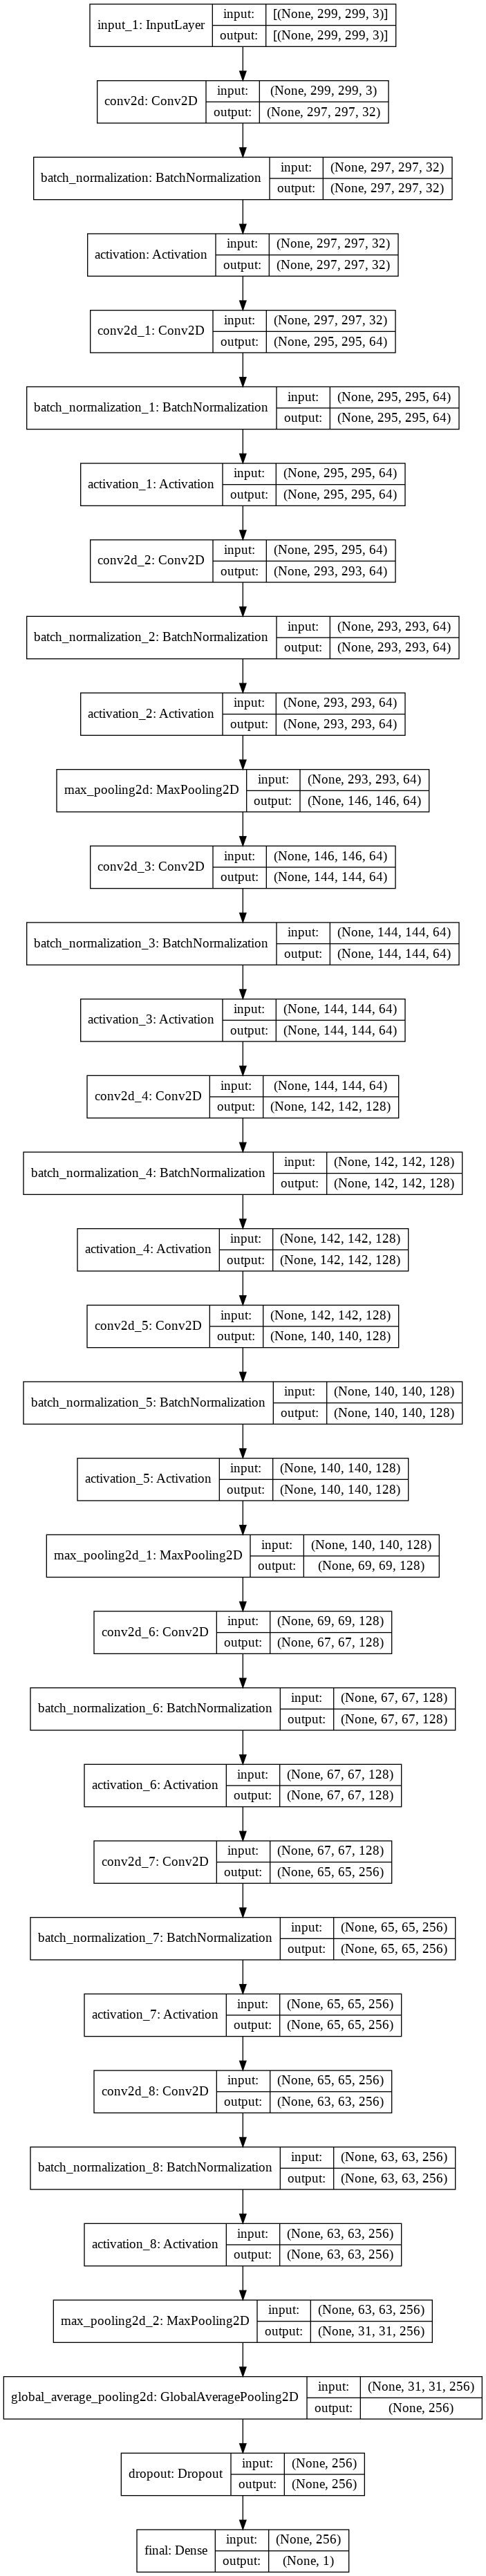

In [ ]:
plot_model(model, to_file= checkpoint_log_plot_dir + model_id + ".png", show_shapes=True)

### Fit model

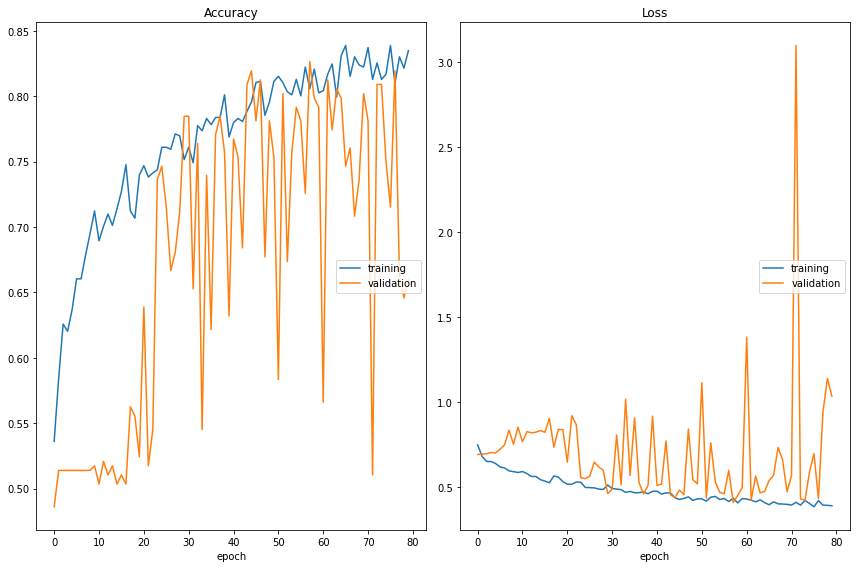

Accuracy
	training         	 (min:    0.536, max:    0.839, cur:    0.835)
	validation       	 (min:    0.486, max:    0.826, cur:    0.660)
Loss
	training         	 (min:    0.387, max:    0.750, cur:    0.393)
	validation       	 (min:    0.412, max:    3.097, cur:    1.036)

No. of epochs ran: 80(expected: 80)


In [ ]:
history = model.fit(                        
    train_iter,
    epochs= epochs,
    validation_data = valid_iter,
    callbacks= my_callbacks,
    initial_epoch=0,
    # steps_per_epoch=100, #None
    validation_steps=None
  )
print("\nNo. of epochs ran: %d(expected: %d)"% (len(history.history["val_loss"]), epochs))

### Load BEST saved model and log.csv

In [ ]:
model = load_model(checkpoint_log_plot_dir+model_id+".h5")
log_dict = pd.read_csv(checkpoint_log_plot_dir+model_id+".csv").to_dict(orient = "list")

### Loading test data(validation data) DATA CHECK

In [ ]:
dft = pd.read_csv(csv_dir+valid_csv,names=["path","label"])
if study_type_list:
  dft_dict = {}
  for study_type in study_type_list:
    dft_dict[study_type] = dft.loc[ dft.path.apply(lambda x: x[16:-40])== study_type ].reset_index(drop=True)
  dft = pd.concat(dft_dict.values(),axis=0).reset_index(drop=True)

test_dict = getImagesInArray(dft,img_height,img_width)
if preprocessing_function:
  test_dict["images"] = preprocessing_function(test_dict["images"])
test_dict["images"].shape

(288, 299, 299, 3)

### Performance Evaluations (conf matrix: rows-true labels, o:neg, 1:pos)(O: speci, 1: sensi)

Confusion Matrix:


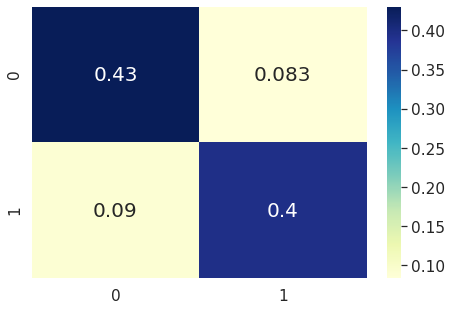

tn: 124      fp: 24      fn: 26      tp: 114


XR_HUMERUS, 
loss                     0.411574
accuracy                 0.826389
precision                0.826087
specifity                0.837838
recall/sensitivity       0.814286
f1_score                 0.820144
Cohen Kappa score        0.652375
prediction error         0.173611

In [ ]:
pred_batch = model.predict(test_dict["images"])
pred = []
for p in pred_batch:
    if(p > 0.5):
        pred+=[1]
    else:
        pred+=[0]

cm = confusion_matrix( test_dict['labels'],pred) #(y_true,y_pred)
tn,fp,fn,tp = cm.ravel()
cm = confusion_matrix( test_dict['labels'],pred,normalize="all") 
Accuracy = (tp+tn)/(tp+tn+fp+fn)
Precision = tp/(tp+fp)
Specifity = tn/(tn+fp)
Recall = tp/(tp+fn)
F1_score = (2*Recall*Precision)/(Recall+Precision)
kap = cohen_kappa_score(test_dict['labels'] , pred)
error = np.sum(np.not_equal(pred, test_dict['labels'])) / test_dict['labels'].shape[0]
loss_overall,_ = model.evaluate(test_dict["images"],test_dict["labels"],verbose=0)

eval_dict = {
    "loss": loss_overall,
    "accuracy": Accuracy,
    "precision": Precision,
    "specifity": Specifity,
    "recall/sensitivity": Recall,
    "f1_score": F1_score,
    "Cohen Kappa score": kap,
    "prediction error": error
}

eval_df_columns = []
str_temp = " "
if study_type_list:
  for study_type in study_type_list:
    str_temp = str_temp+study_type +", "
  eval_df_columns.append(str_temp)
else:
  eval_df_columns = ["Overall"]
  str_temp = "Overall"

eval_df = pd.DataFrame.from_dict(eval_dict,orient = "index",columns=eval_df_columns)

#Confusion Matrix
print('Confusion Matrix:')
import seaborn as sn
plt.figure(figsize = (7.5,5))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()
print("tn:",tn,"     fp:",fp,"     fn:",fn,"     tp:",tp)
eval_df

### Curves

**Learning curves**

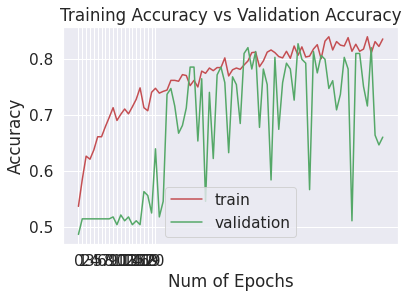

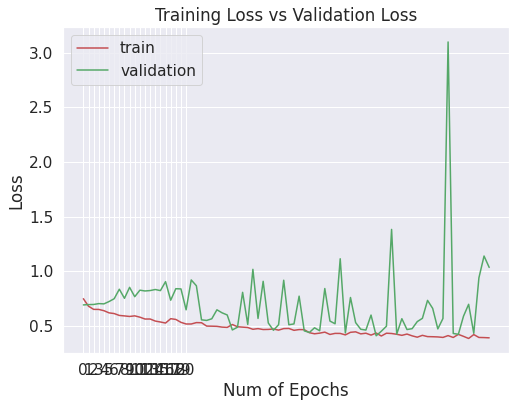

In [ ]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(log_dict['acc'],'r')
plt.plot(log_dict['val_acc'],'g')
plt.xticks(np.arange(0, 21, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(log_dict['loss'],'r')
plt.plot(log_dict['val_loss'],'g')
plt.xticks(np.arange(0, 21, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

**ROC Curve**

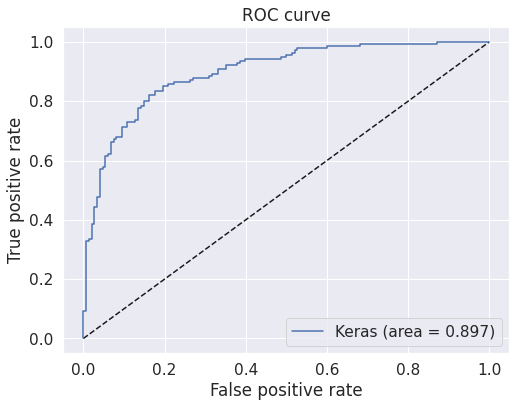

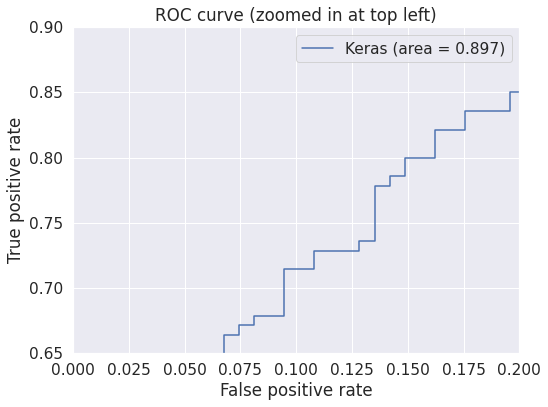

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_dict['labels'], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Study wise Model Analysis(Assuming best model is loaded, here losses are calculated)

In [ ]:
study_types = ["XR_ELBOW", "XR_SHOULDER", "XR_HAND", "XR_FINGER", "XR_WRIST", "XR_HUMERUS", "XR_FOREARM" ]
def study_wise_model_analysis(model, valid_csv,preprocess_fn,imgh,imgw):
  
  lr = 0.0001
  opt=  Adam(learning_rate=lr)
  loss='binary_crossentropy'
  metrics=['acc']
   
  model.compile(optimizer=opt, loss = loss, metrics=metrics)

  df = pd.read_csv(csv_dir+valid_csv,names=["path","label"])
  df_dict = {}
  pred_dict = {}
  loss_dict = {}
  acc_dict = {}
  pred_error_dict = {}
  kappa_dict = {}
  Precision = {}
  Specifity = {}
  Recall = {}
  F1_score = {}
  
  for study_type in study_types:
    #Create df of that study_type
    df_dict[study_type] = df.loc[ df.path.apply(lambda x: x[16:-40])== study_type ]
    #LOAD IMAGES
    images = []
    labels = []
    valid_dict = {}
    pred_batch = None
    for i, data in (df_dict[study_type].iterrows()):
      img = tf.keras.preprocessing.image.load_img(data_dir+data['path'],color_mode='rgb',target_size=(imgh,imgw))
      img = keras.preprocessing.image.img_to_array(img,dtype="float32")
      images.append(img)
      labels.append(data['label'])
    images = np.asarray(images)
    labels = np.asarray(labels)
    valid_dict =  {'images': images, 'labels': labels}
    
    valid_dict["images"] = preprocess_fn(valid_dict["images"])

    #Evaluations(loss, acc, preds, )
    loss_dict[study_type], acc_dict[study_type]  = model.evaluate(valid_dict["images"],valid_dict["labels"],verbose=0)
    pred_batch = model.predict(valid_dict["images"])
    pred_dict[study_type] = []
    for p in pred_batch:
      if(p > 0.5):
        pred_dict[study_type]+=[1]
      else:
        pred_dict[study_type]+=[0]
    pred_error_dict[study_type] = np.sum(np.not_equal(pred_dict[study_type], valid_dict['labels'])) / valid_dict['labels'].shape[0]
    kappa_dict[study_type] = cohen_kappa_score( valid_dict['labels'] , pred_dict[study_type])
    
    cm = confusion_matrix( valid_dict['labels'],np.asarray(pred_dict[study_type])) #(y_true,y_pred)
    tn,fp,fn,tp = cm.ravel()
    Precision[study_type] = tp/(tp+fp)
    Specifity[study_type] = tn/(tn+fp)
    Recall[study_type] = tp/(tp+fn)
    F1_score[study_type] = (2*Recall[study_type]*Precision[study_type])/(Recall[study_type]+Precision[study_type])
  
  list_of_dicts = [loss_dict, acc_dict, Precision, Specifity, Recall, F1_score, kappa_dict,pred_error_dict]
  
  df_temp = pd.DataFrame(list_of_dicts,index=["loss","accuracy", "precision", "specifity", "recall/sensitivity", "f1_score","Cohen Kappa score", "prediction error"])
  df_temp.insert(7,str_temp,eval_dict.values())
  return df_temp

In [ ]:
study_wise_model_analysis(model, valid_csv, standardize,img_height,img_width)

XR_ELBOW  XR_SHOULDER  ...  XR_FOREARM   XR_HUMERUS, 
loss                0.689449     0.975613  ...    0.710904       0.411574
accuracy            0.658065     0.568384  ...    0.690000       0.826389
precision           0.726115     0.554517  ...    0.739496       0.826087
specifity           0.817021     0.498246  ...    0.793333       0.837838
recall/sensitivity  0.495652     0.640288  ...    0.586667       0.814286
f1_score            0.589147     0.594324  ...    0.654275       0.820144
Cohen Kappa score   0.313733     0.138271  ...    0.380000       0.652375
prediction error    0.341935     0.431616  ...    0.310000       0.173611

[8 rows x 8 columns]

## Grad-CAM visualisations

### Functions

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def grad_cam_vis(valid_csv, study_type, preprocess_fn, model, last_conv_layer_name, classifier_layer_names, number, size_tuple):
  plt.rcParams['figure.figsize'] = (18*2, 6*5)
  for i in range(number):
    dfv = pd.read_csv(csv_dir+valid_csv,names=["path","label"])
    if study_type:
      dfv = dfv.loc[ dfv.path.apply(lambda x: x[16:-40])== study_type ].reset_index(drop=True)
    
    rand_num = randint(0,dfv.shape[0]-1)
  

    img = tf.keras.preprocessing.image.load_img(data_dir + dfv.path[rand_num],color_mode='rgb',target_size= size_tuple)
    img = keras.preprocessing.image.img_to_array(img,dtype="float32")

    #Backup
    imgB = np.copy(img)
    if preprocess_fn:
      img = preprocess_fn(img)
    img = np.expand_dims(img,0)

    predict = None
    preds = model.predict(img)
    if(preds > 0.5):
      predict = 1
    else:
      predict = 0

    plt.subplot(number,3,3*i+1).set_title("Actual : "+str(dfv.label[rand_num])+"  ;  Predicted : "+str(predict)+"["+str(preds)+"]"+"/nImg Dir: "+dfv.path[rand_num][-16:-40]+"/"+dfv.path[rand_num][-39:])
    plt.imshow((imgB*1./255))#.astype("uint8"))
    plt.axis('off')
    

  
    heatmap = make_gradcam_heatmap(
        img, model, last_conv_layer_name, classifier_layer_names
    )
    heatmap = np.uint8(255 * heatmap)
    plt.subplot(number,3,3*i+2)
    plt.imshow(heatmap)
    plt.axis('off')

    jet = cma.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  
    superimposed_img = jet_heatmap * 0.4 + imgB
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plt.subplot(number,3,3*i+3)
    plt.imshow(superimposed_img)
    plt.axis('off')
  return

### Inputs

In [ ]:
# model = load_model(checkpoint_log_plot_dir+"4.h5")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 297, 297, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 297, 297, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 64)      18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 295, 295, 64)      192       
_________________________________________________________________
activation_1 (Activation)    (None, 295, 295, 64)      0     

In [ ]:
last_conv_layer_name = "activation_8" #mixed6 #block14_sepconv2_act (can be concatenate layer or Activation Layer)
classifier_layer_names = [
    "global_average_pooling2d",#"avg_pool",
    "final"#"predictions"
]

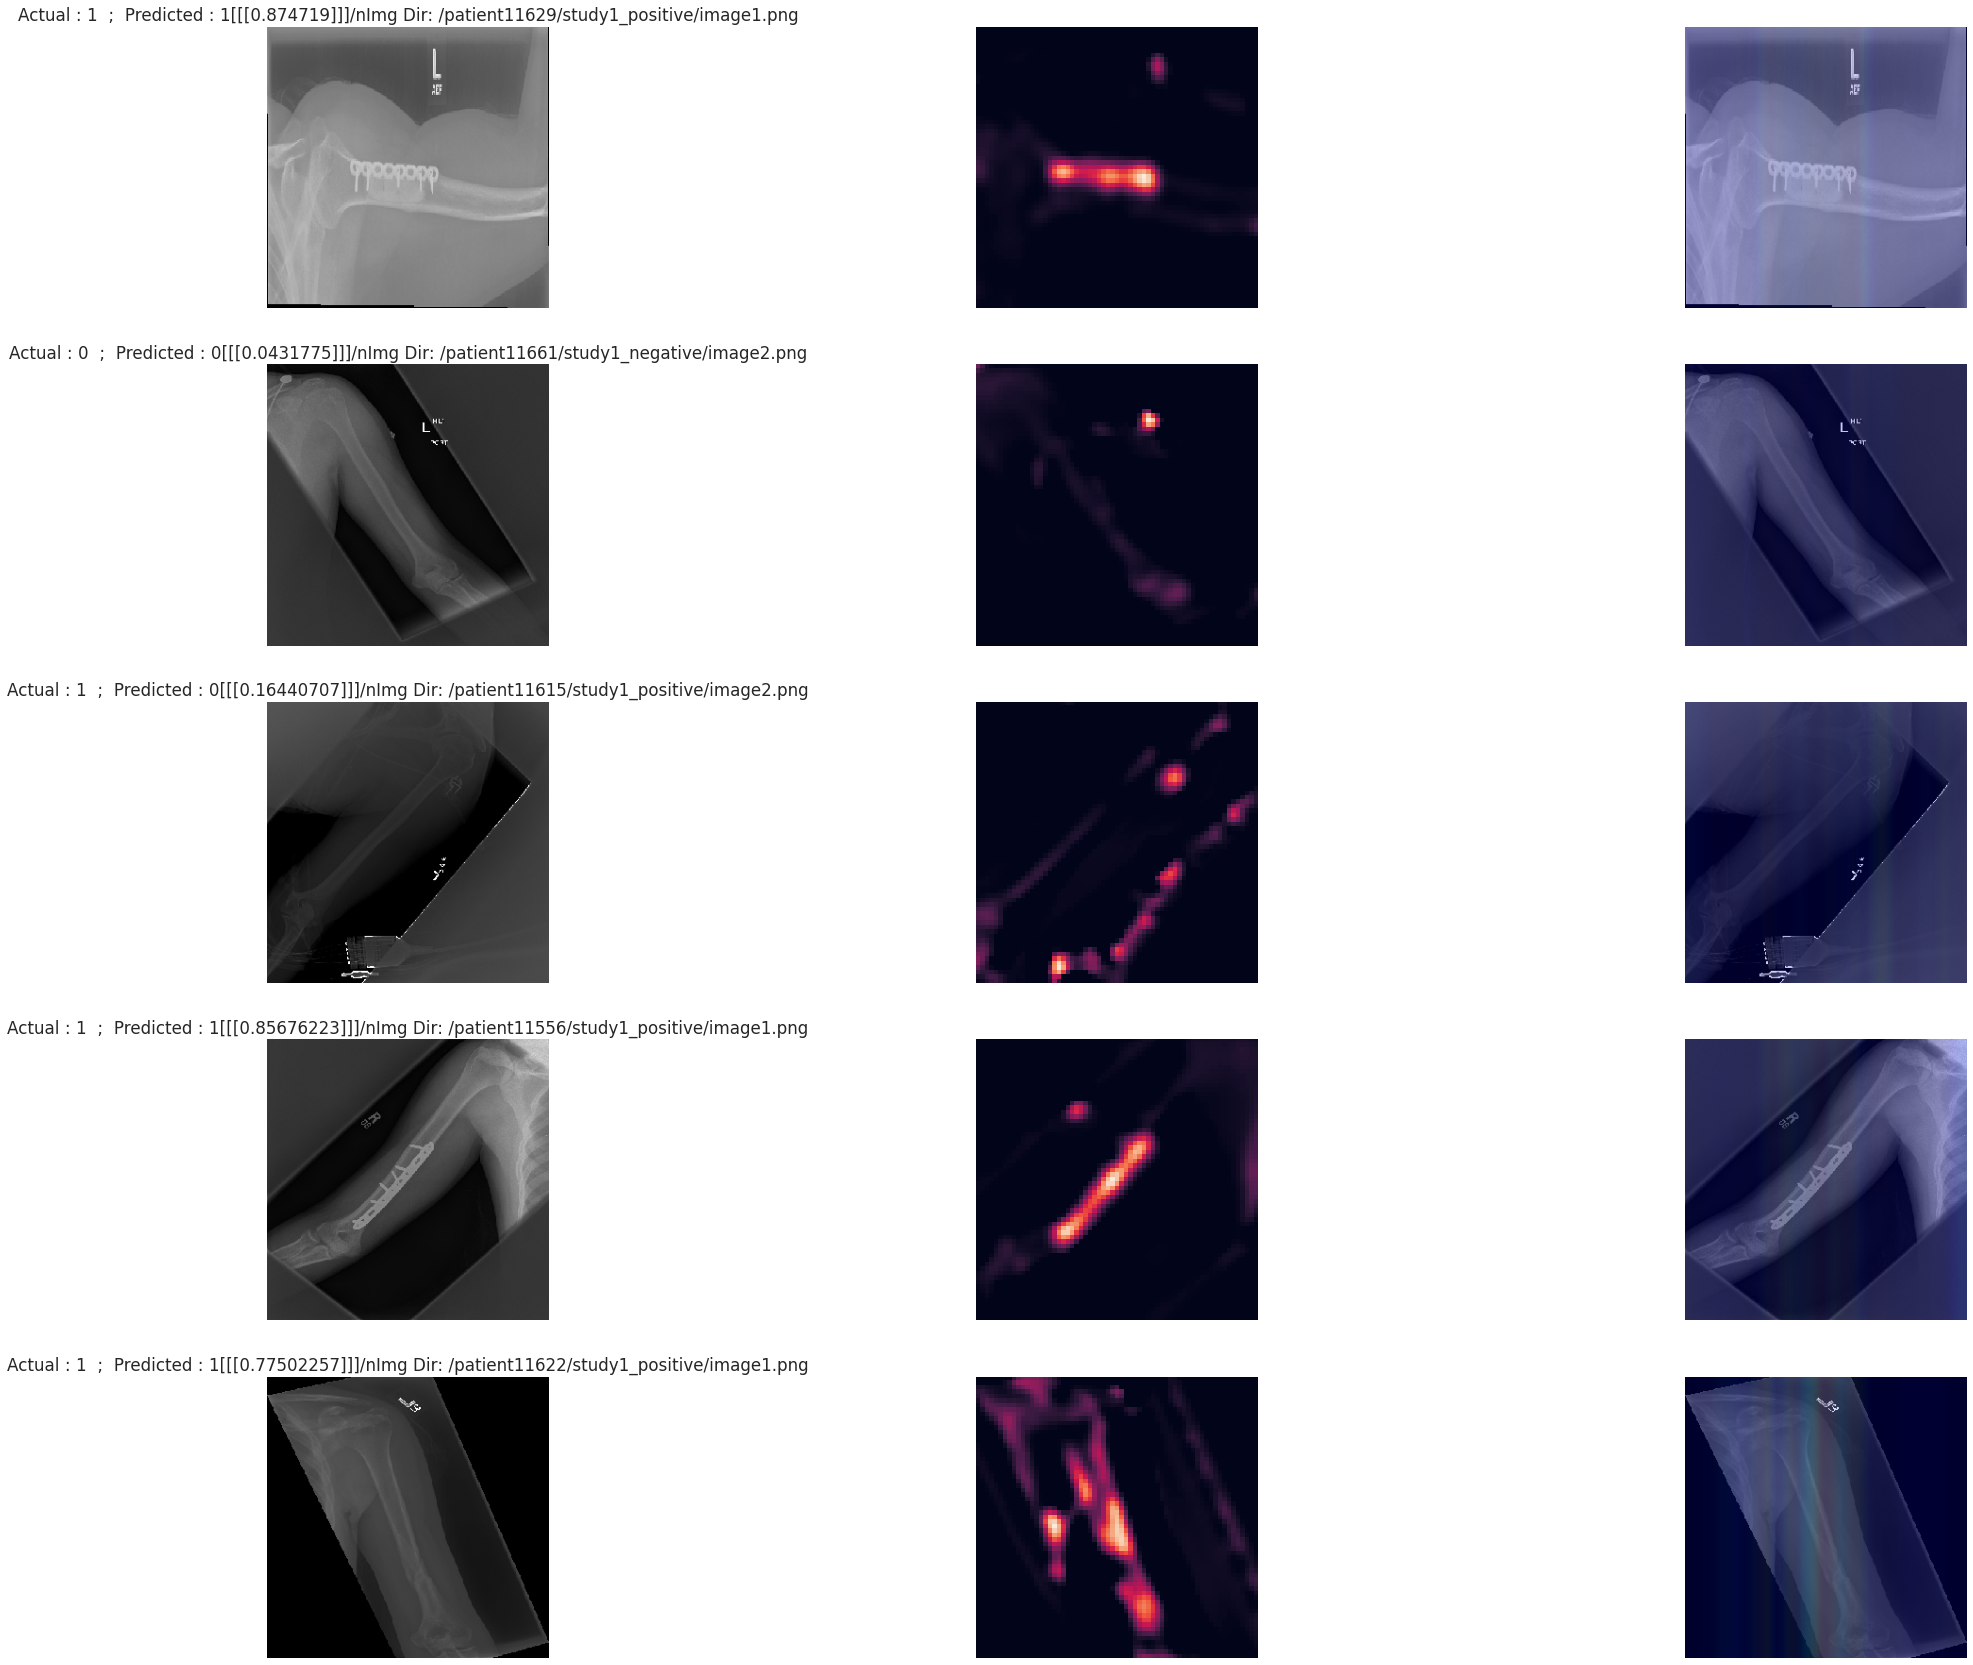

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

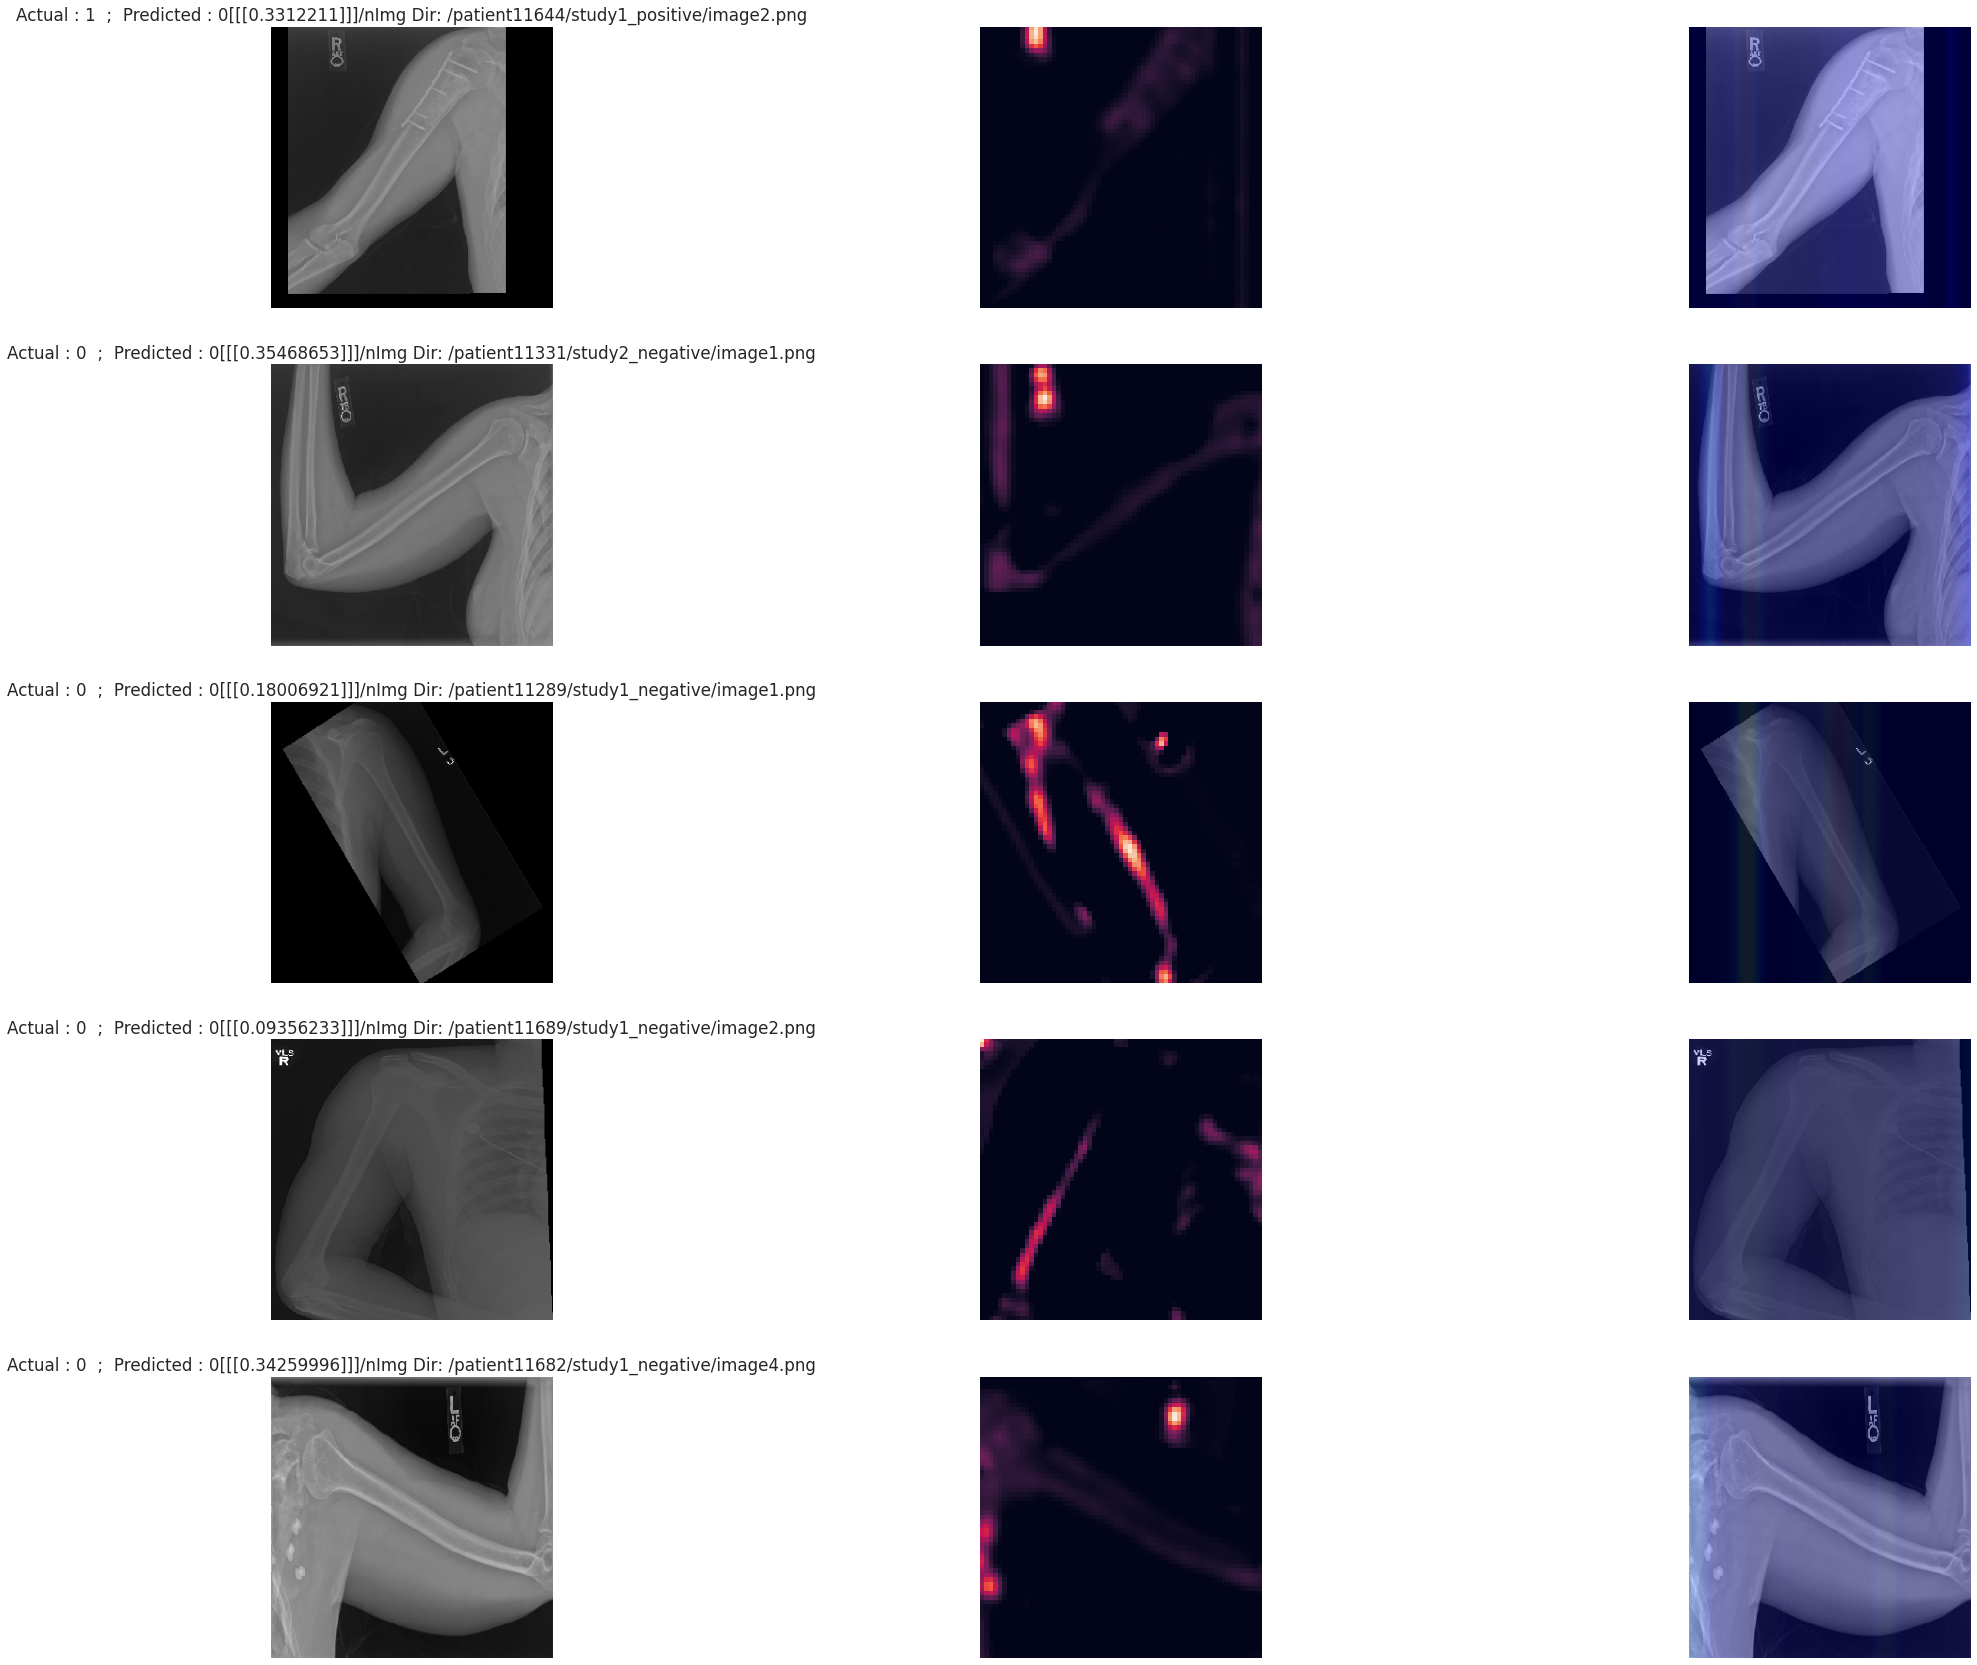

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

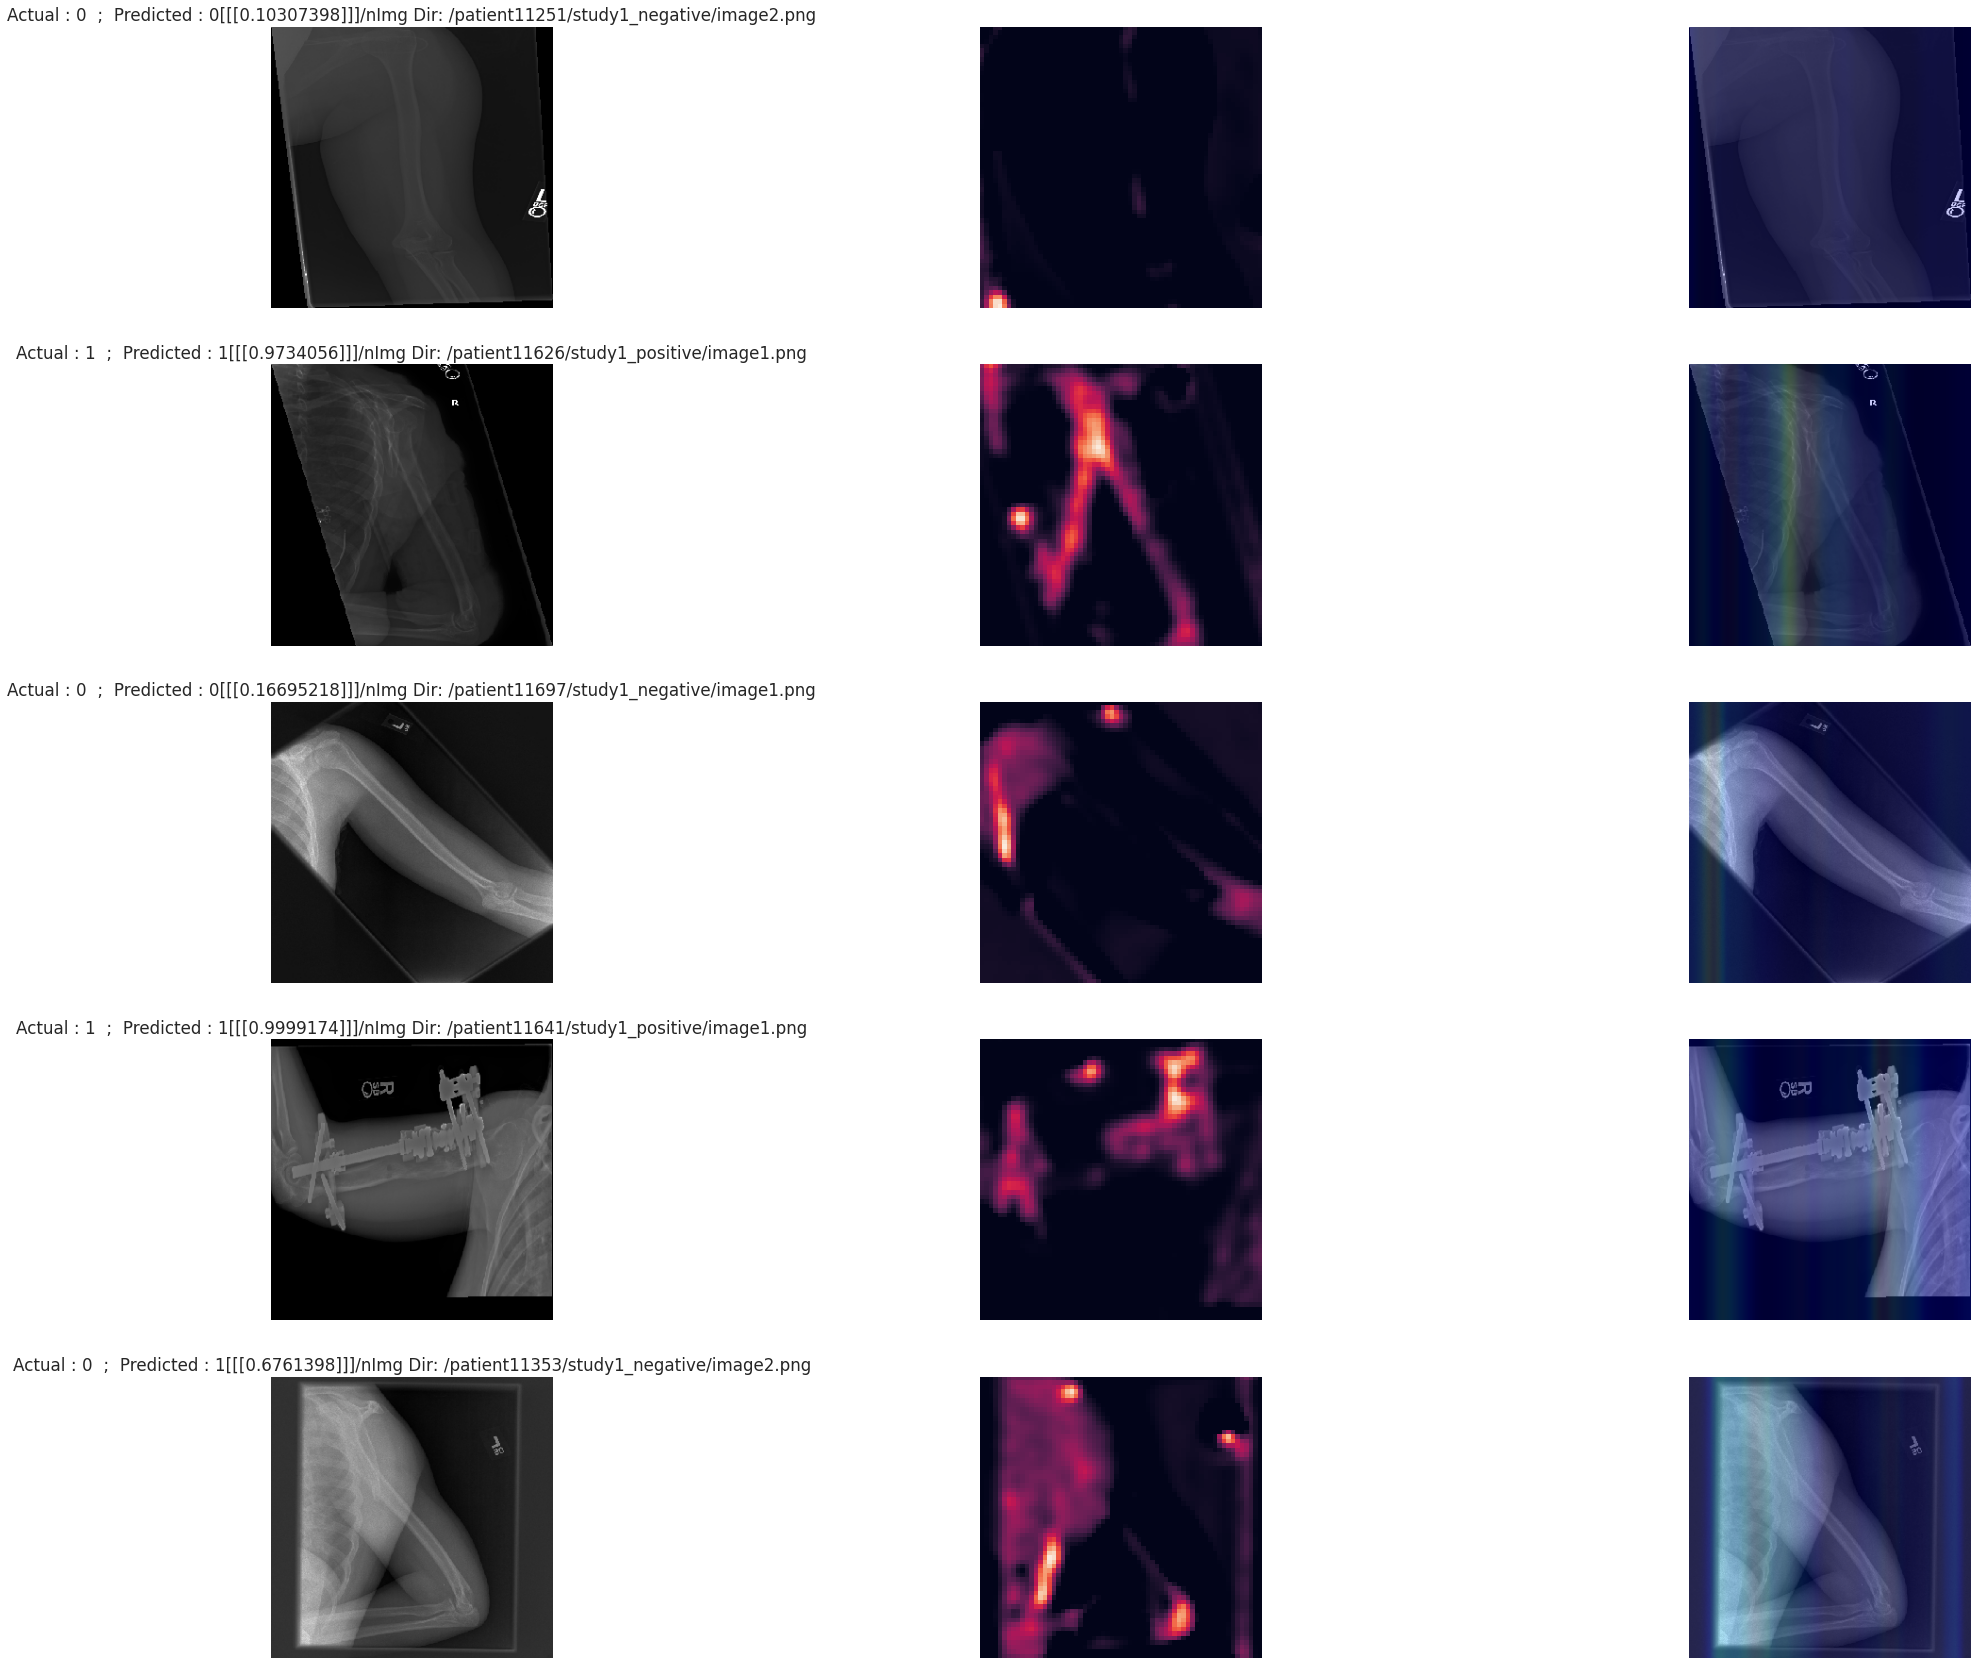

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

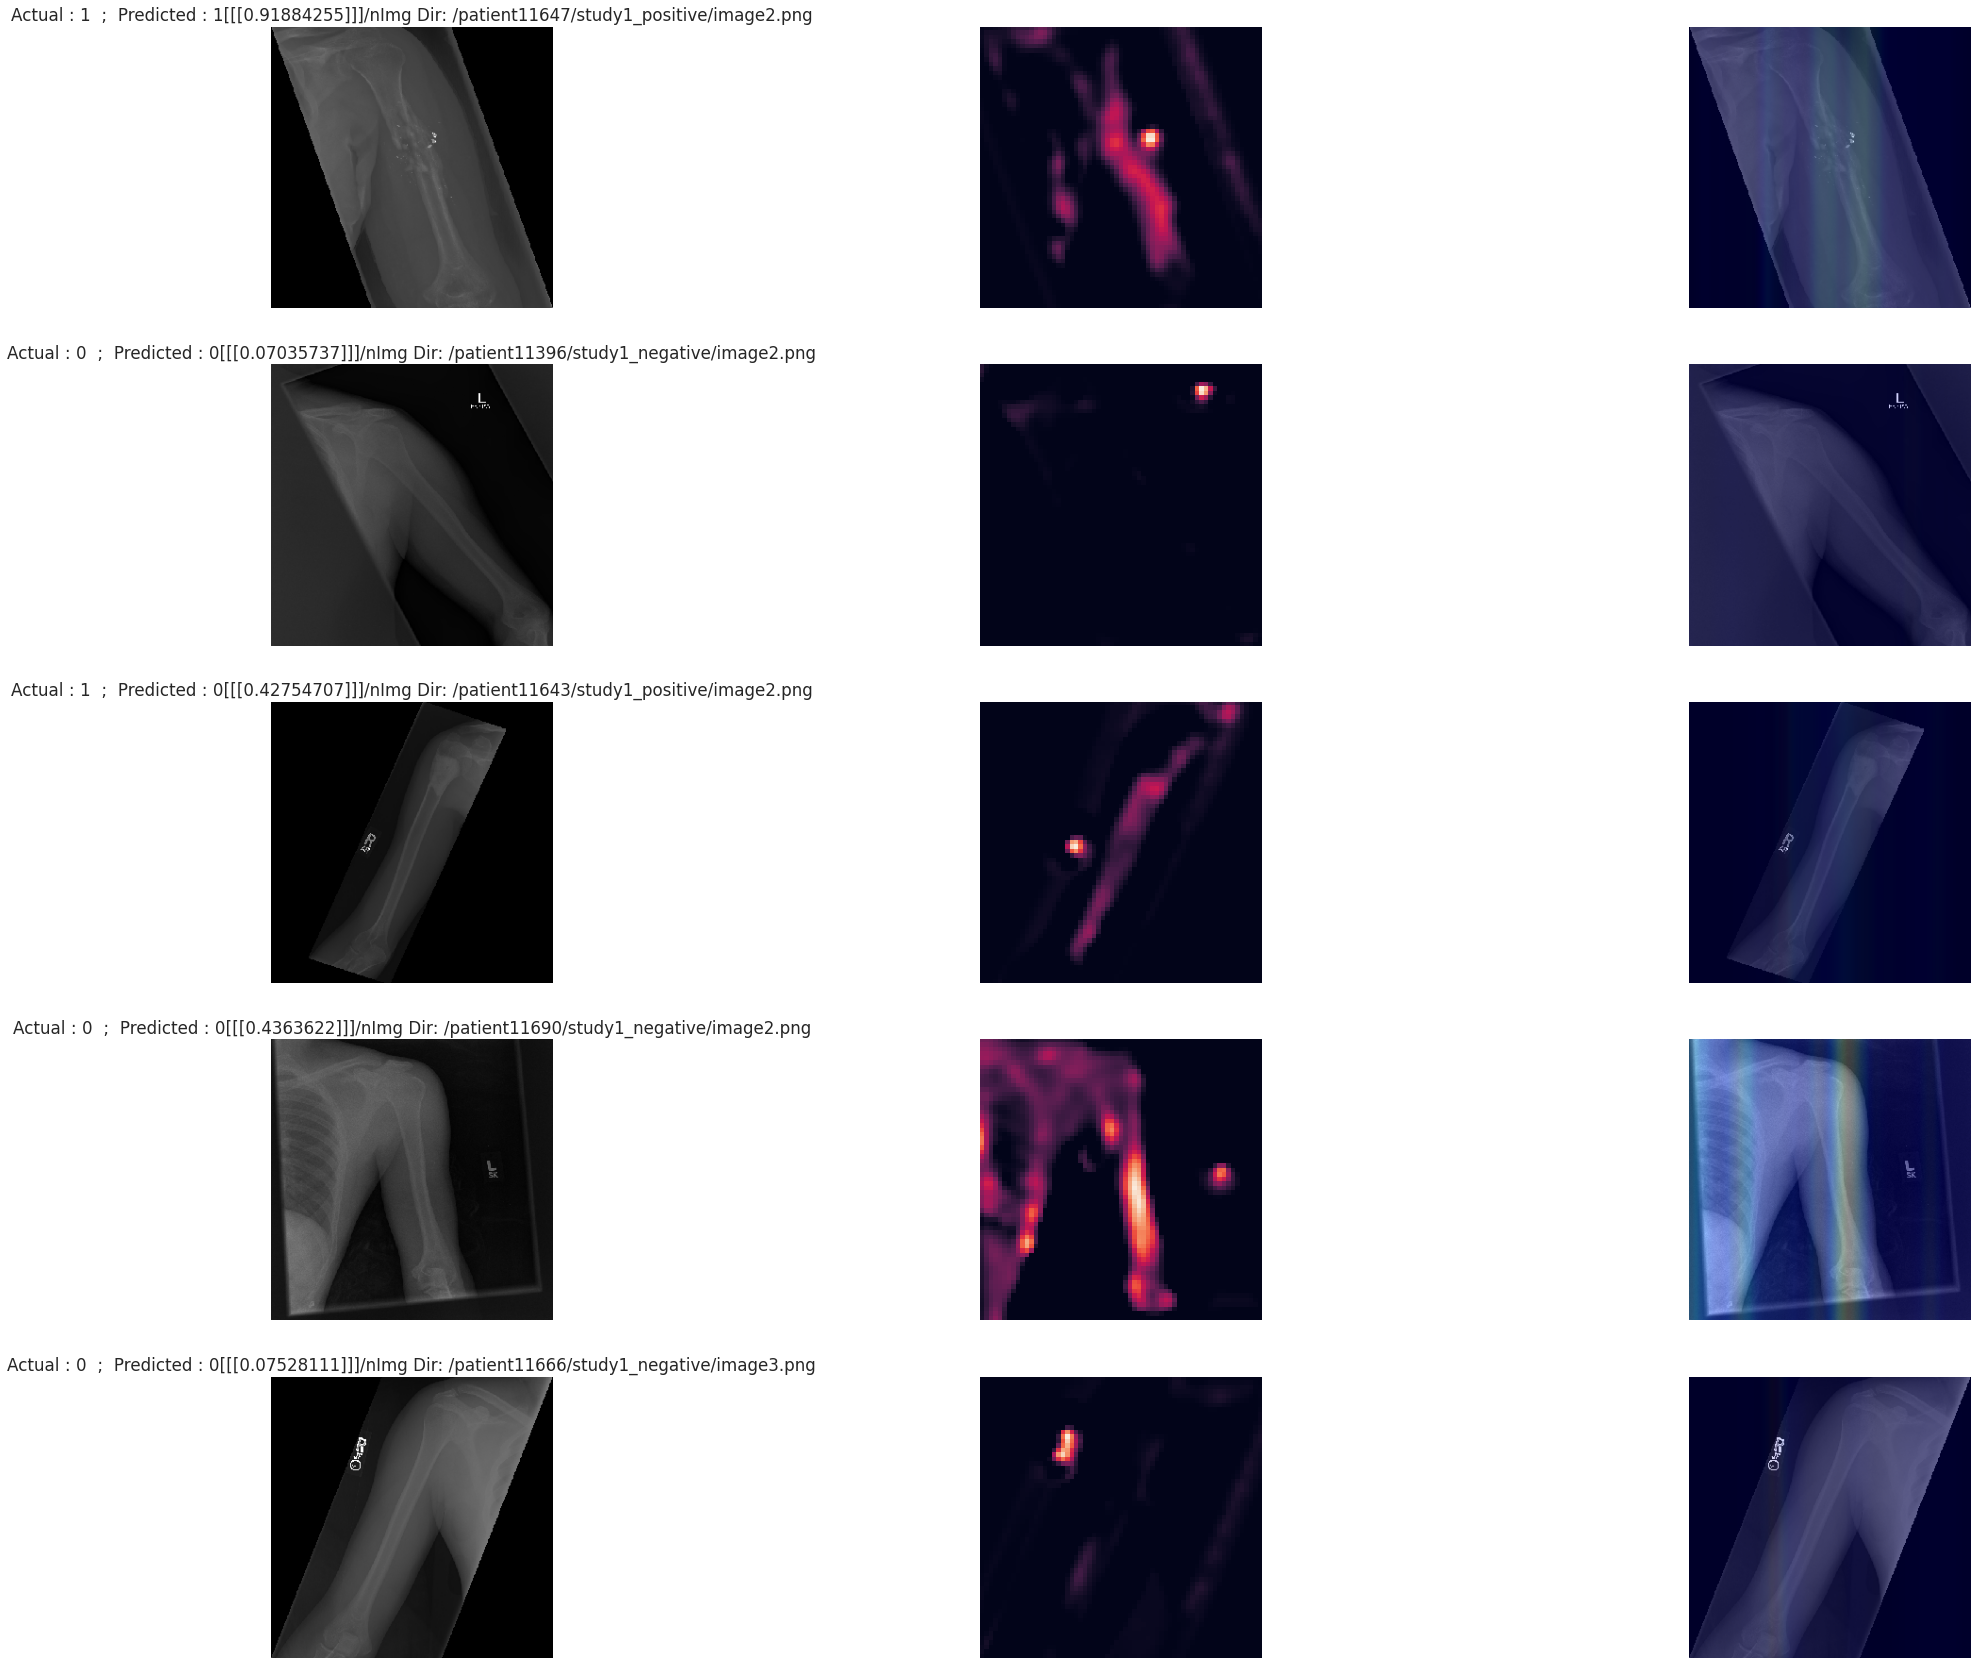

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

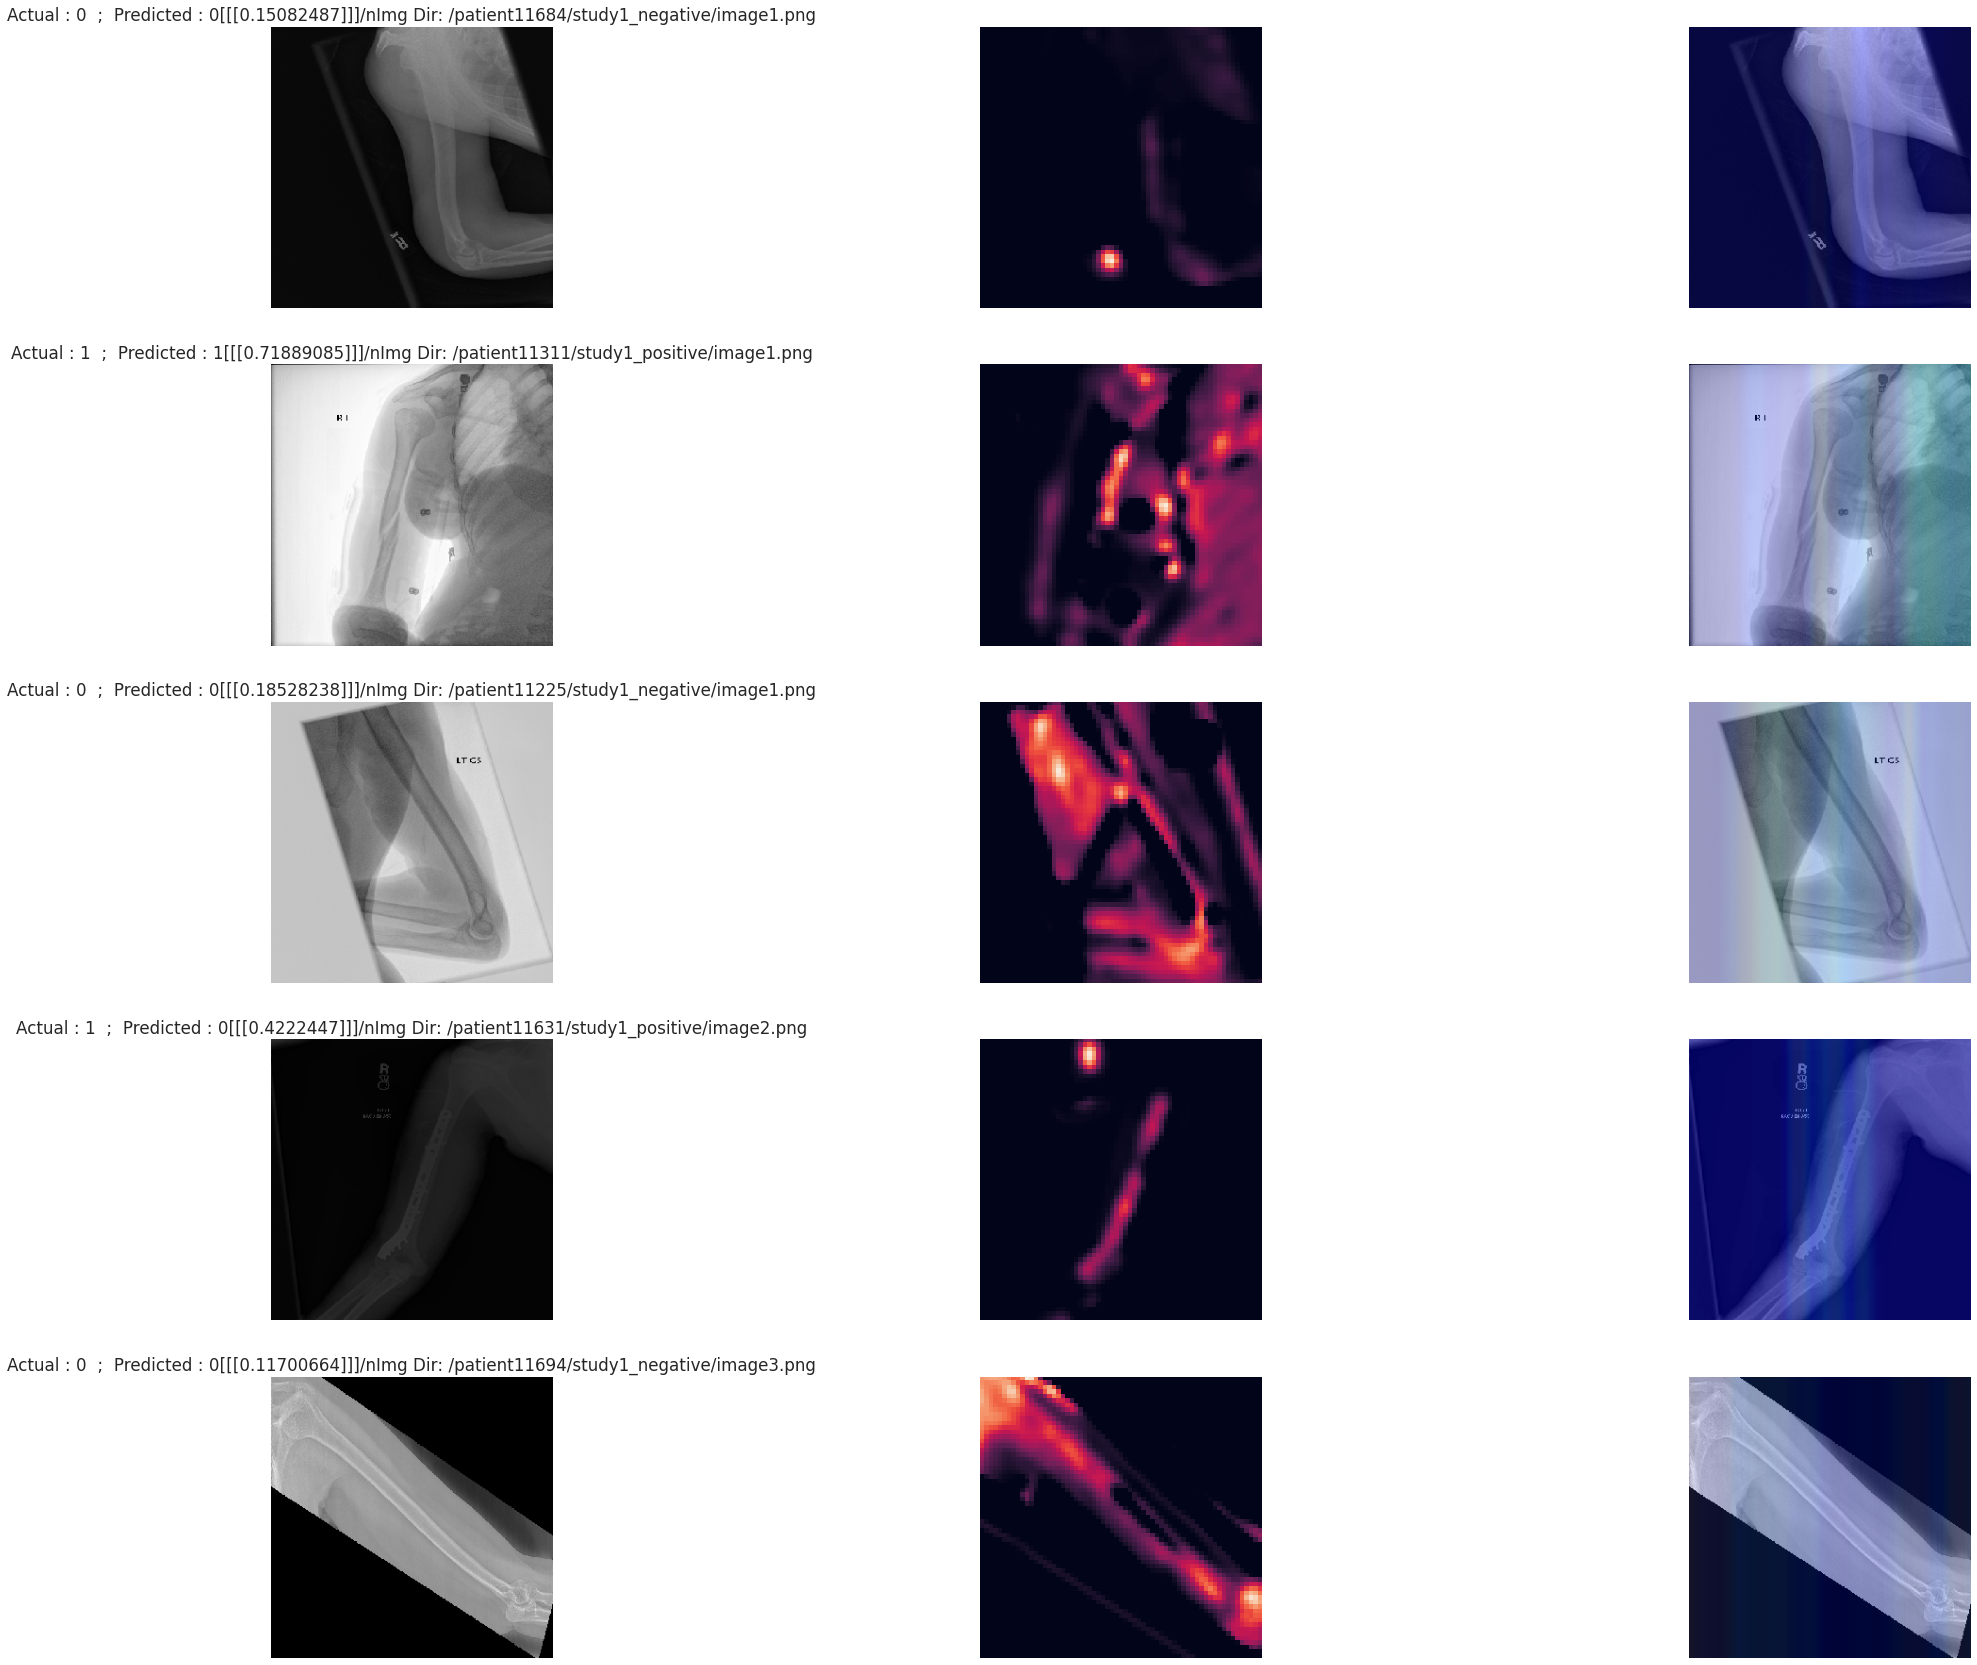

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

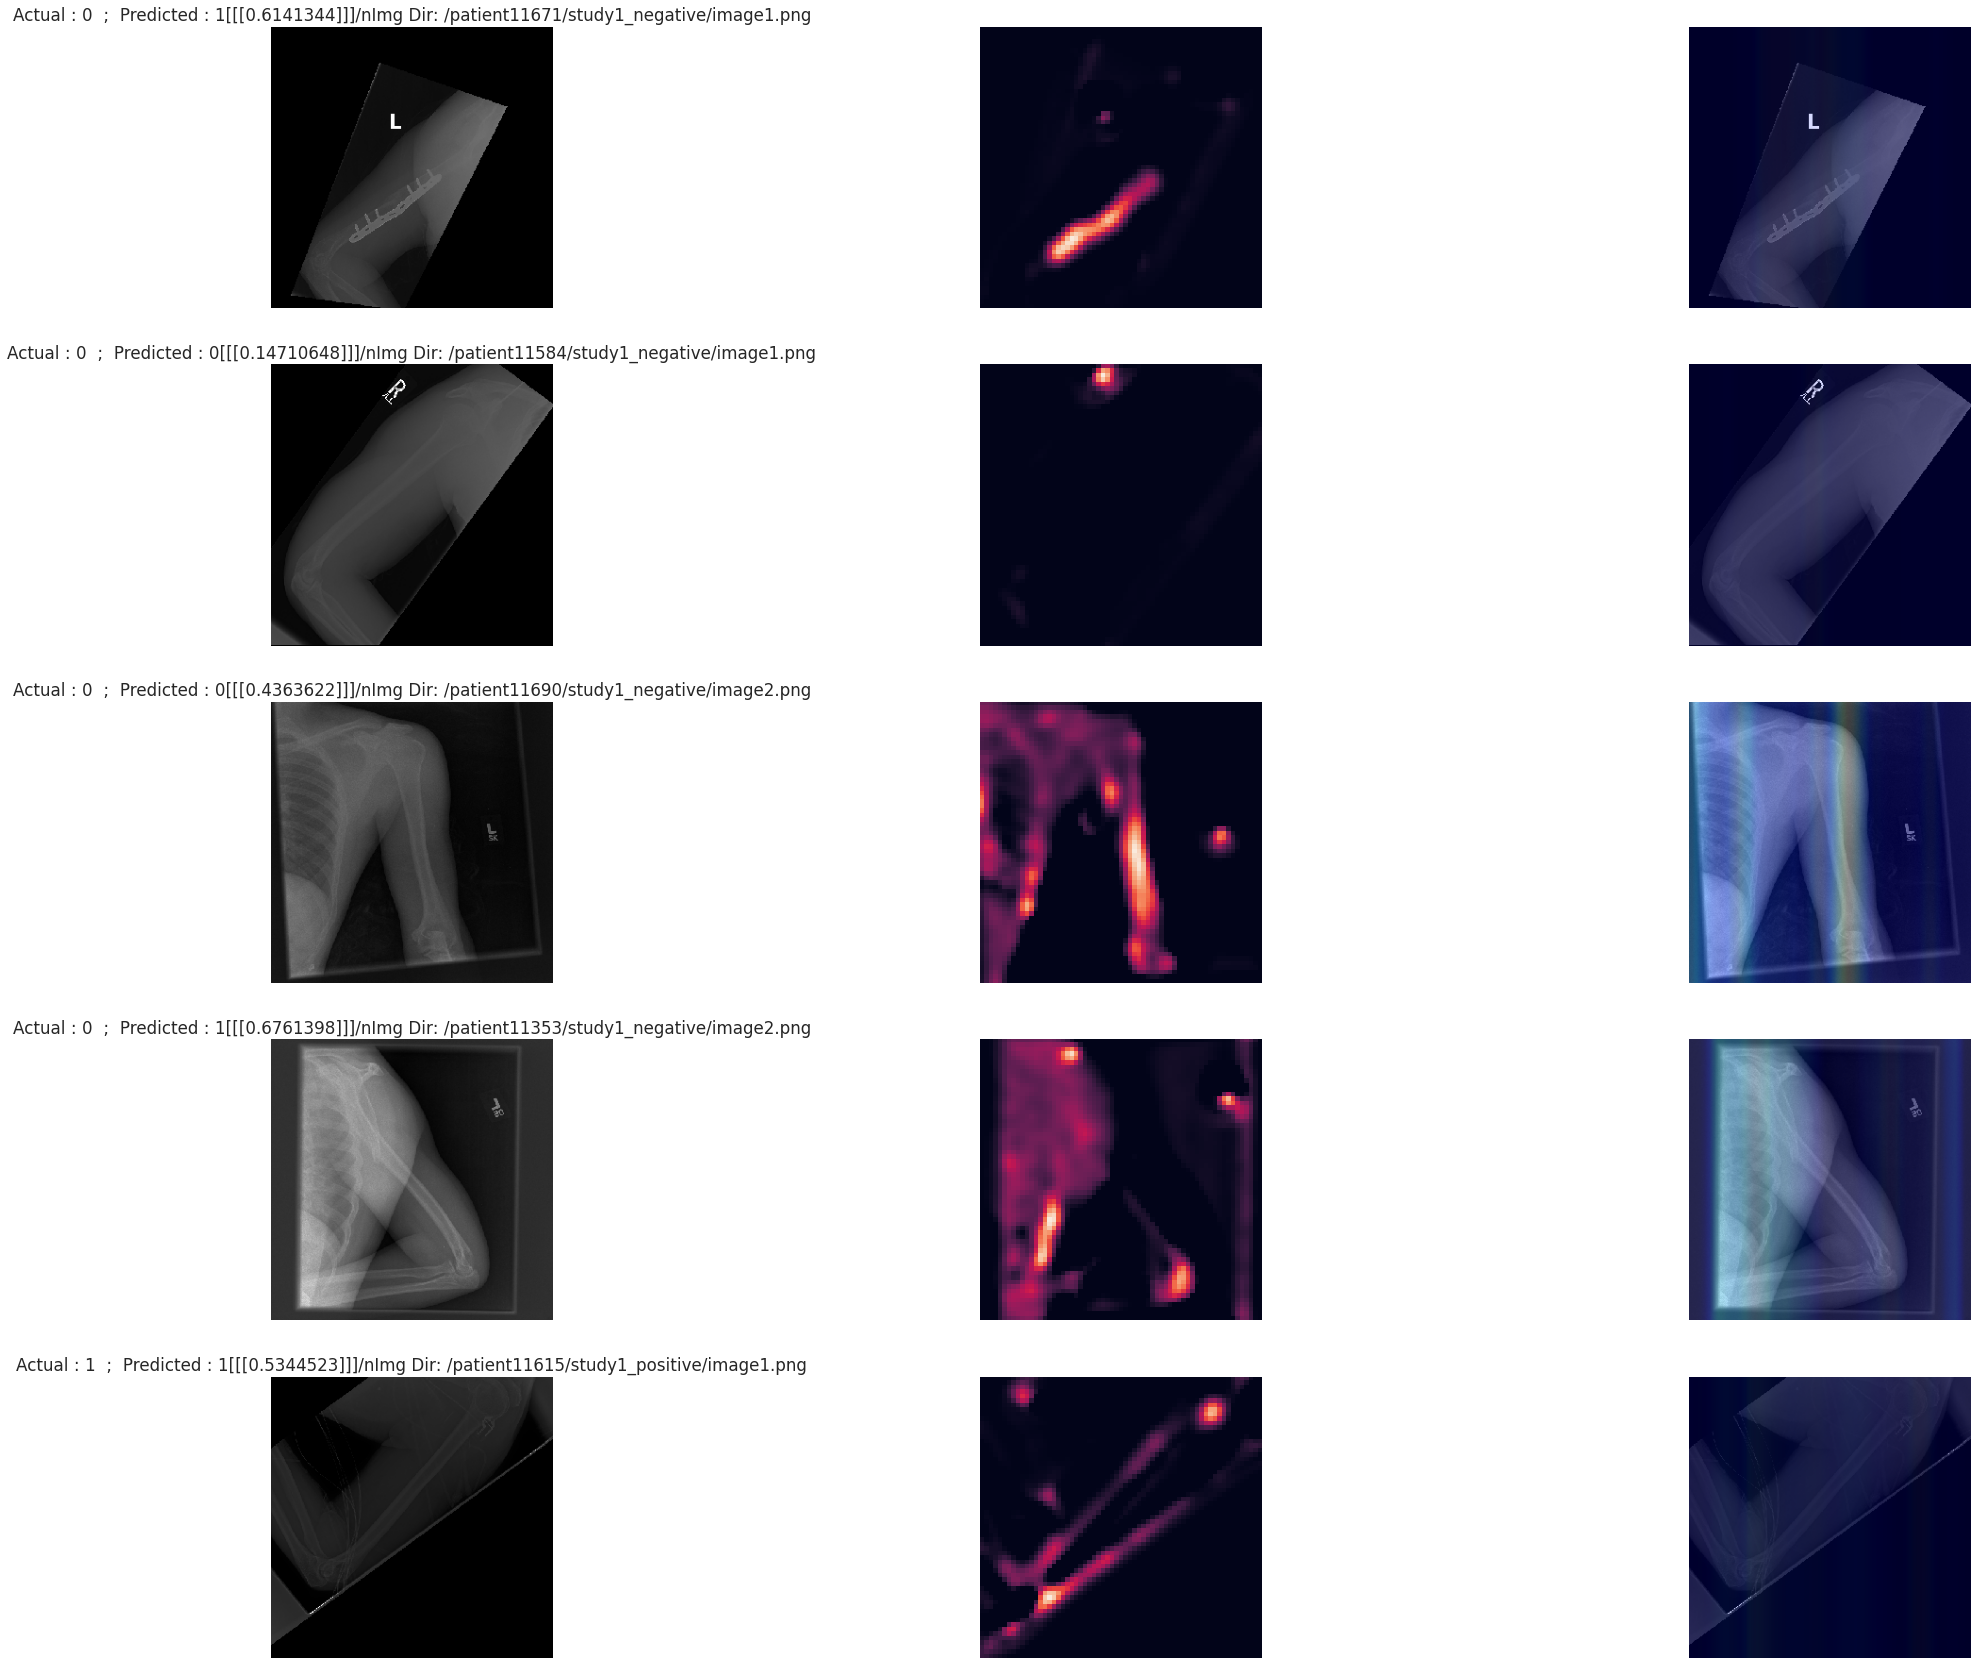

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

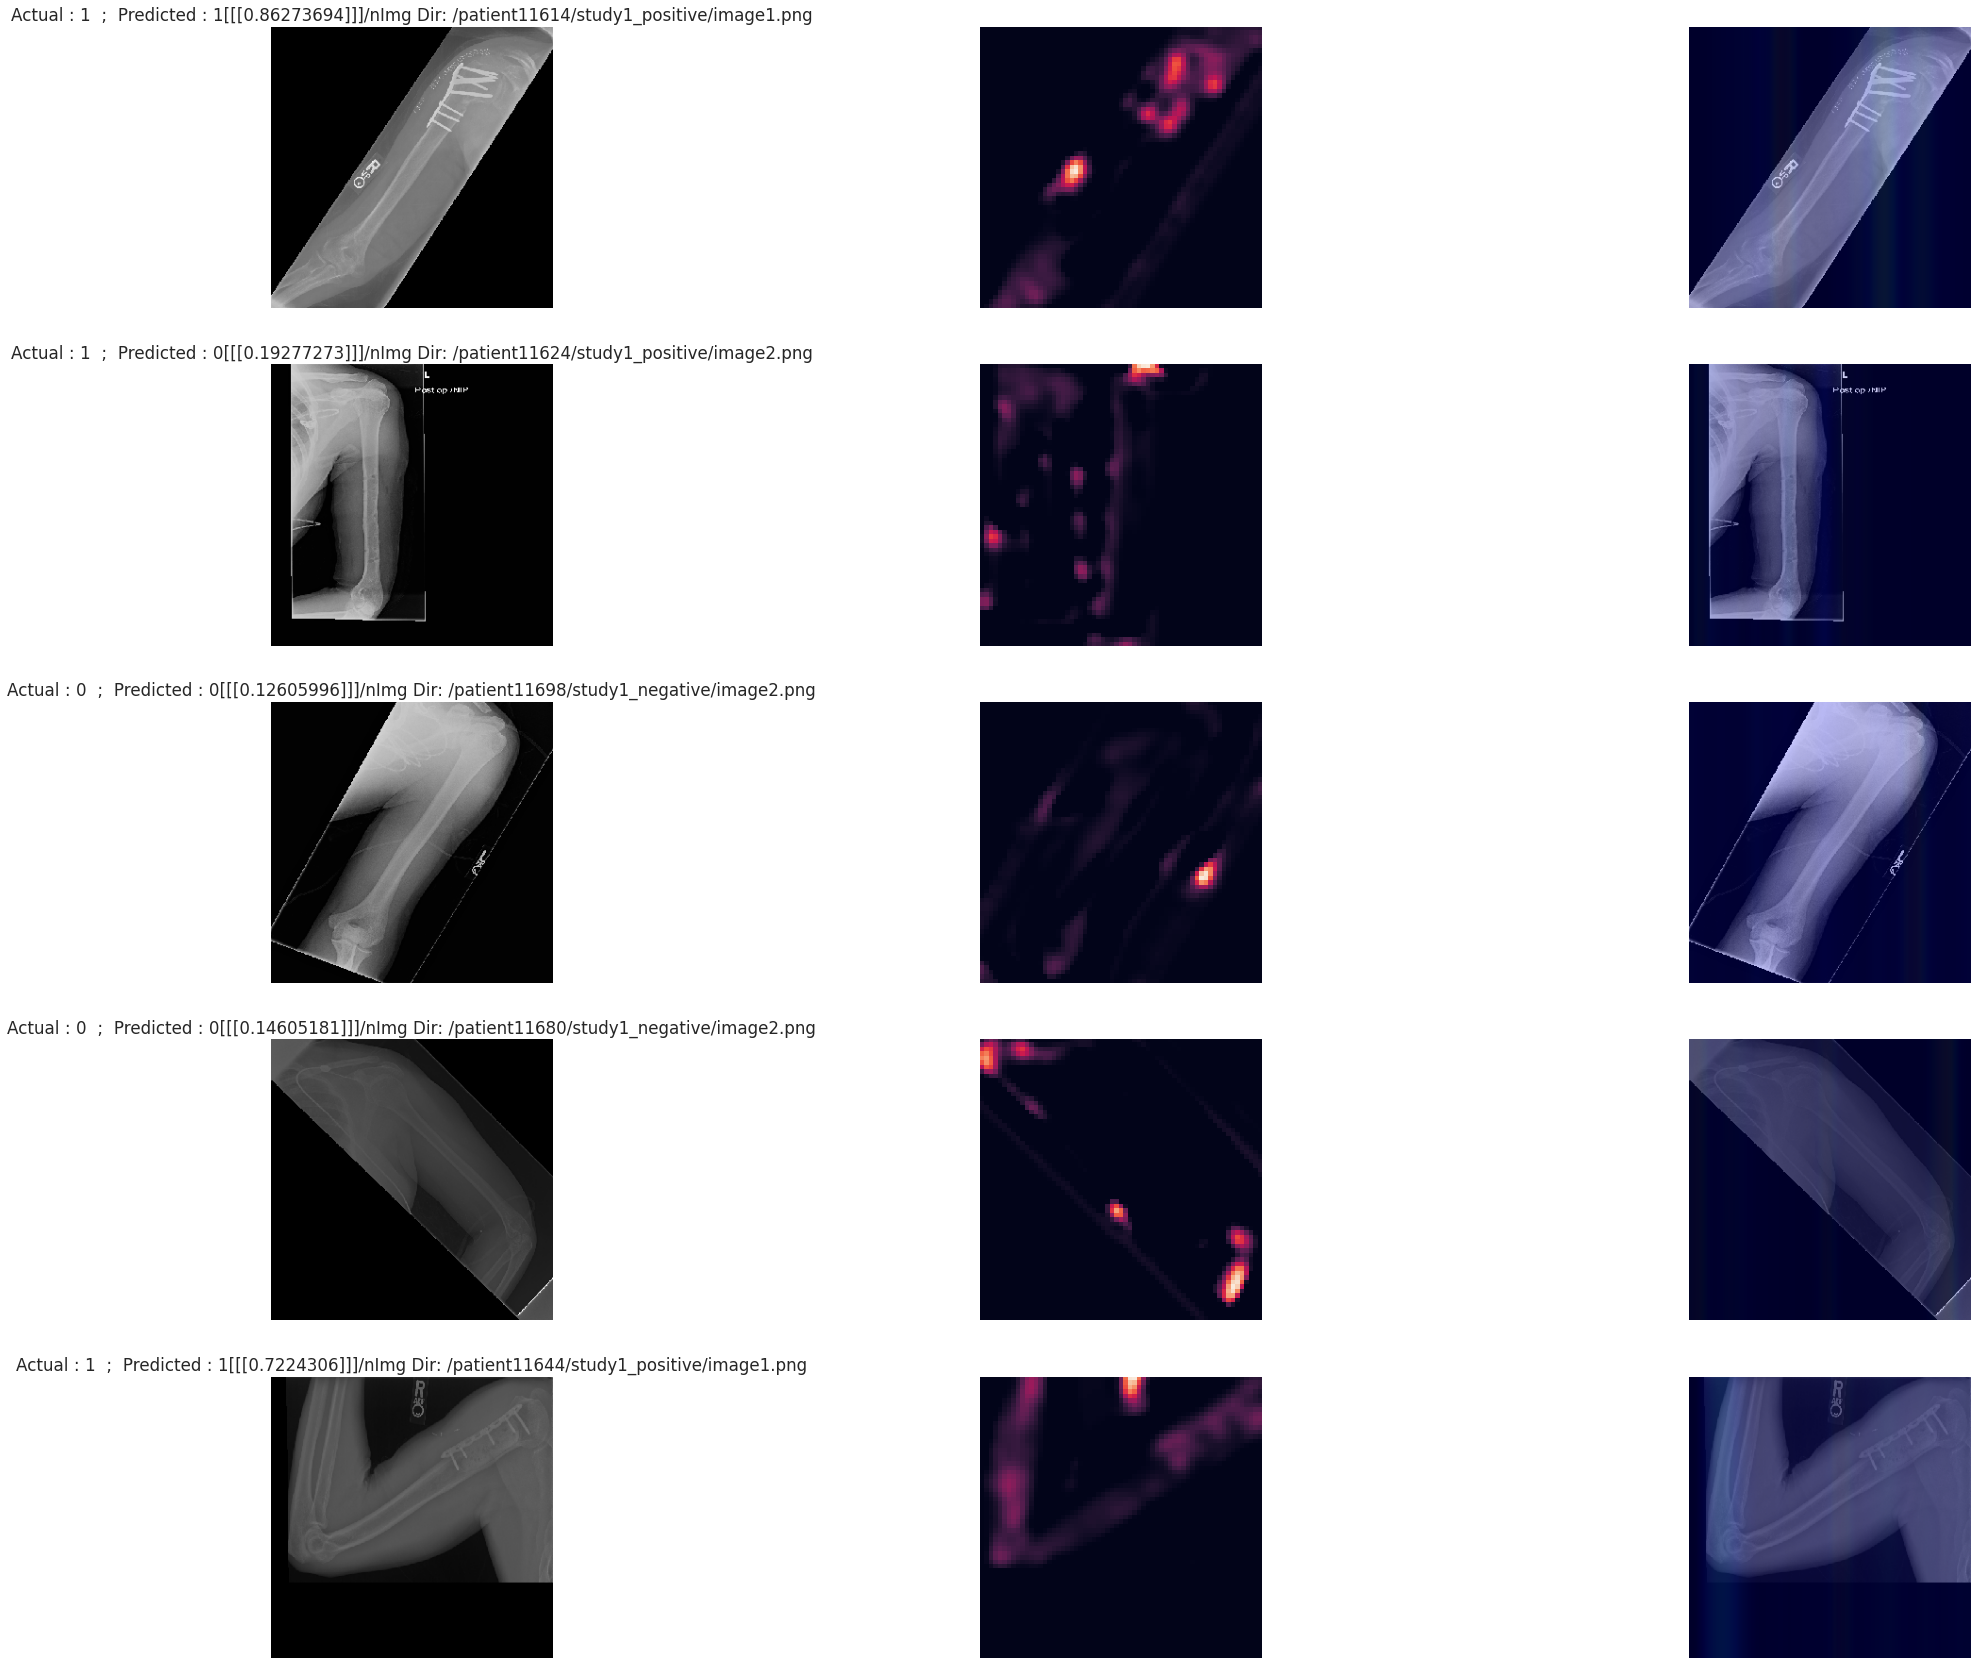

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

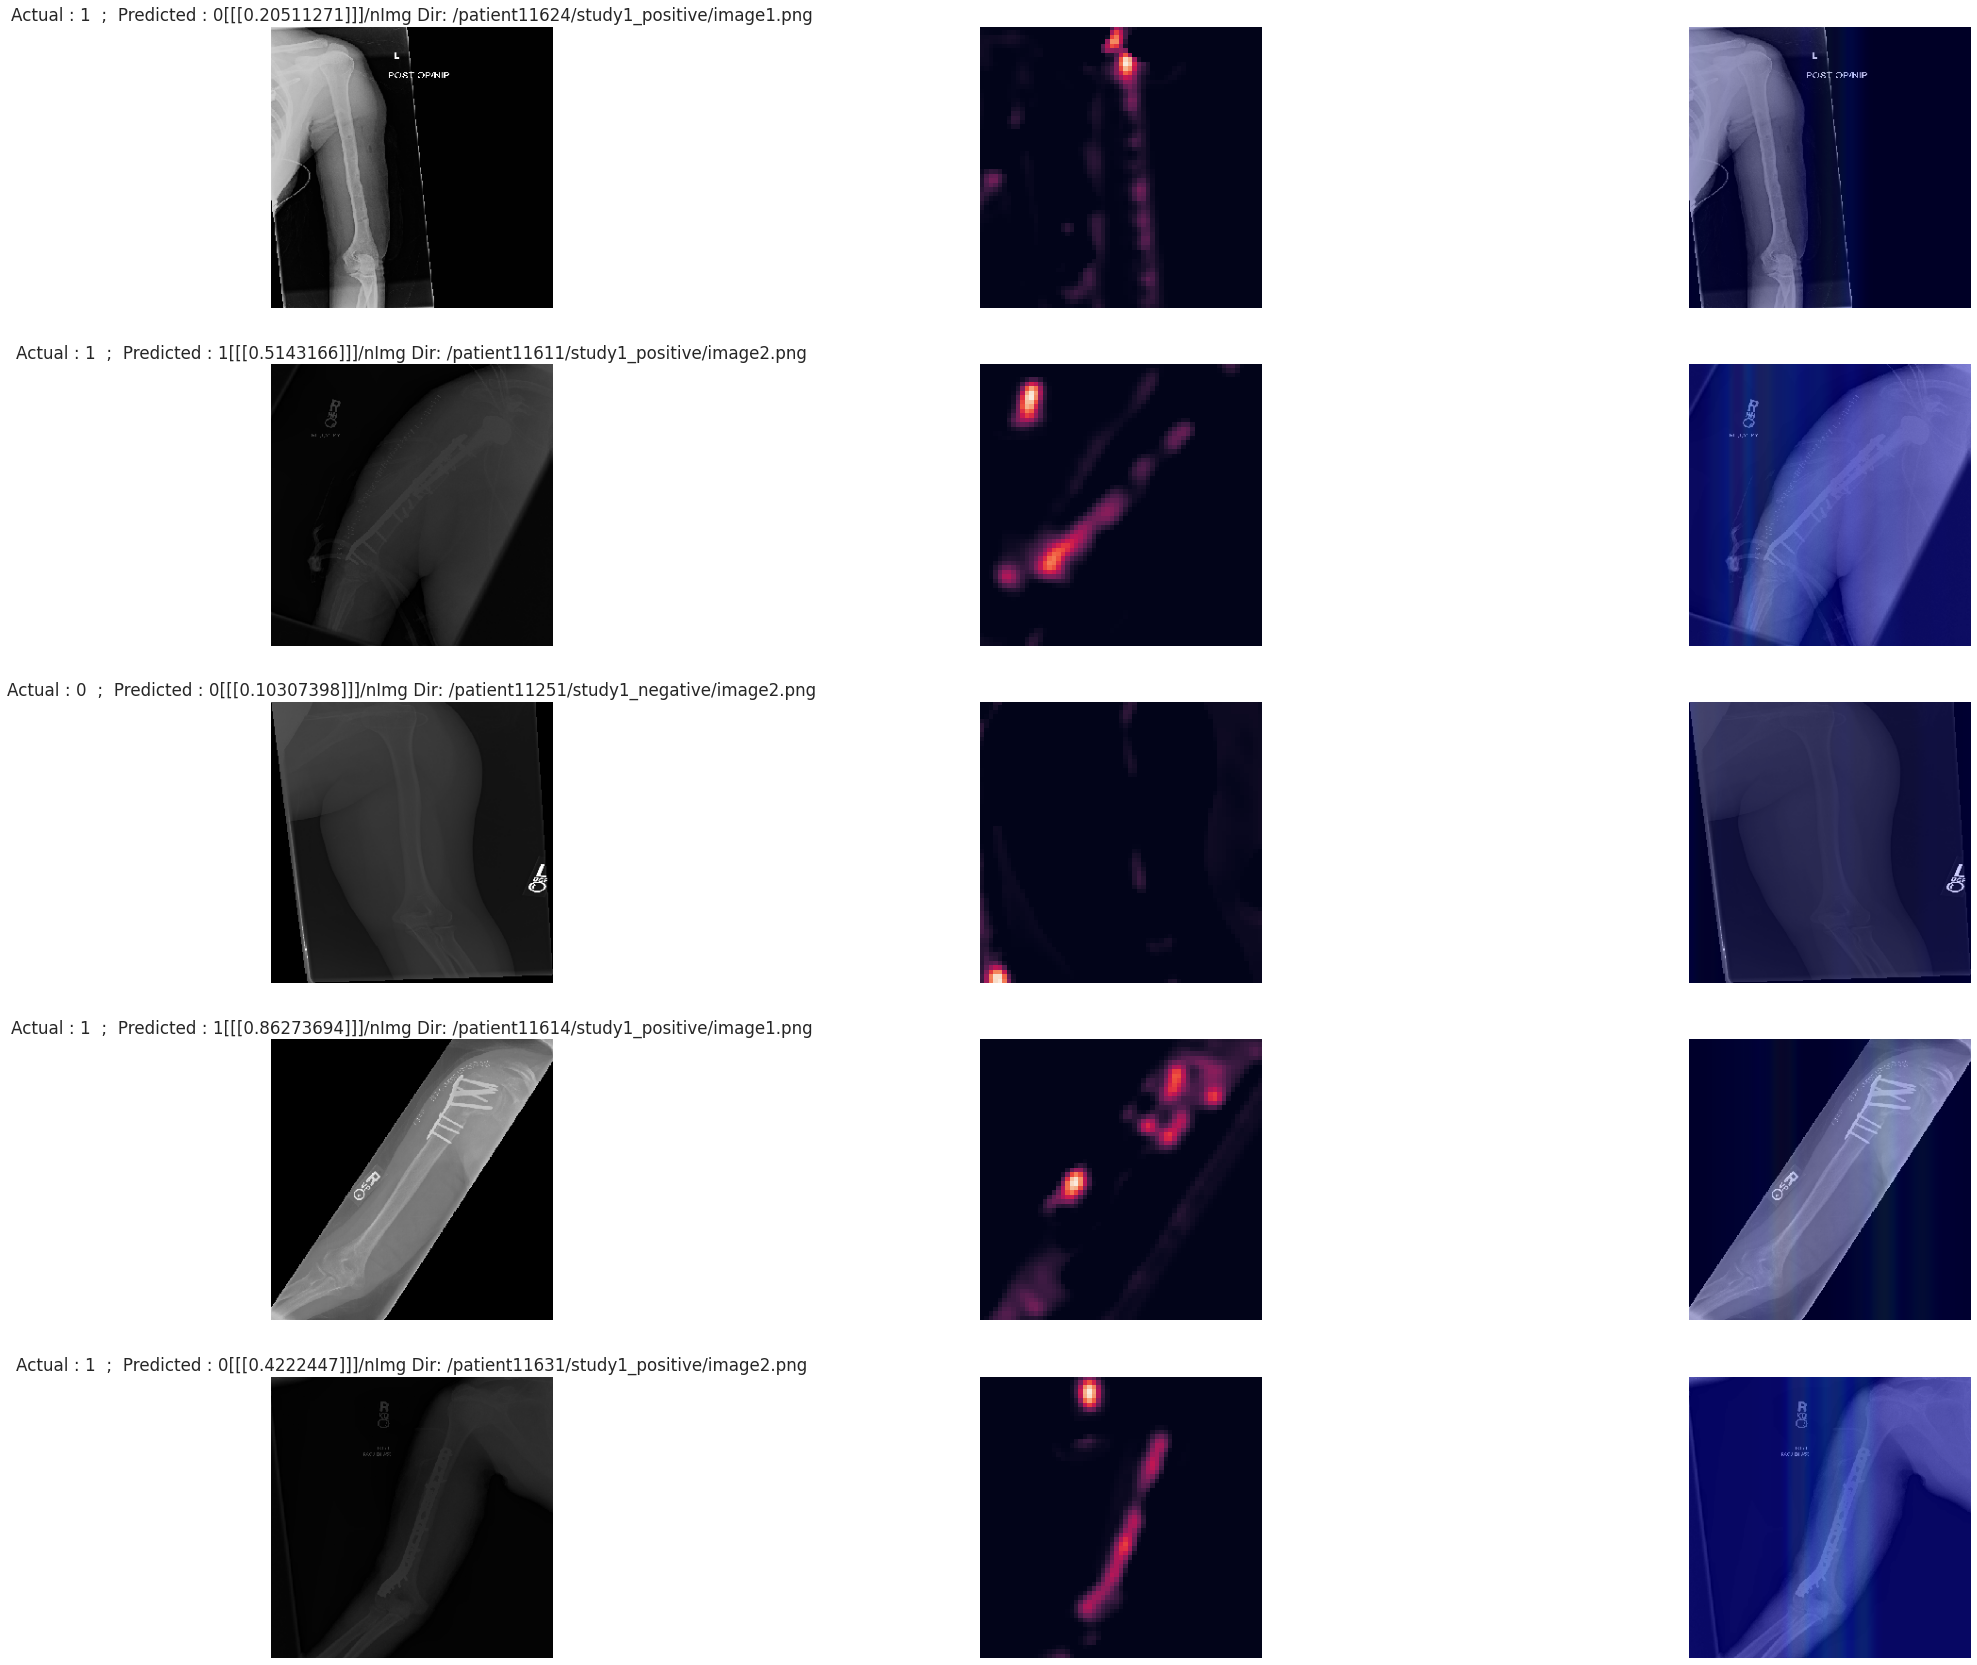

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

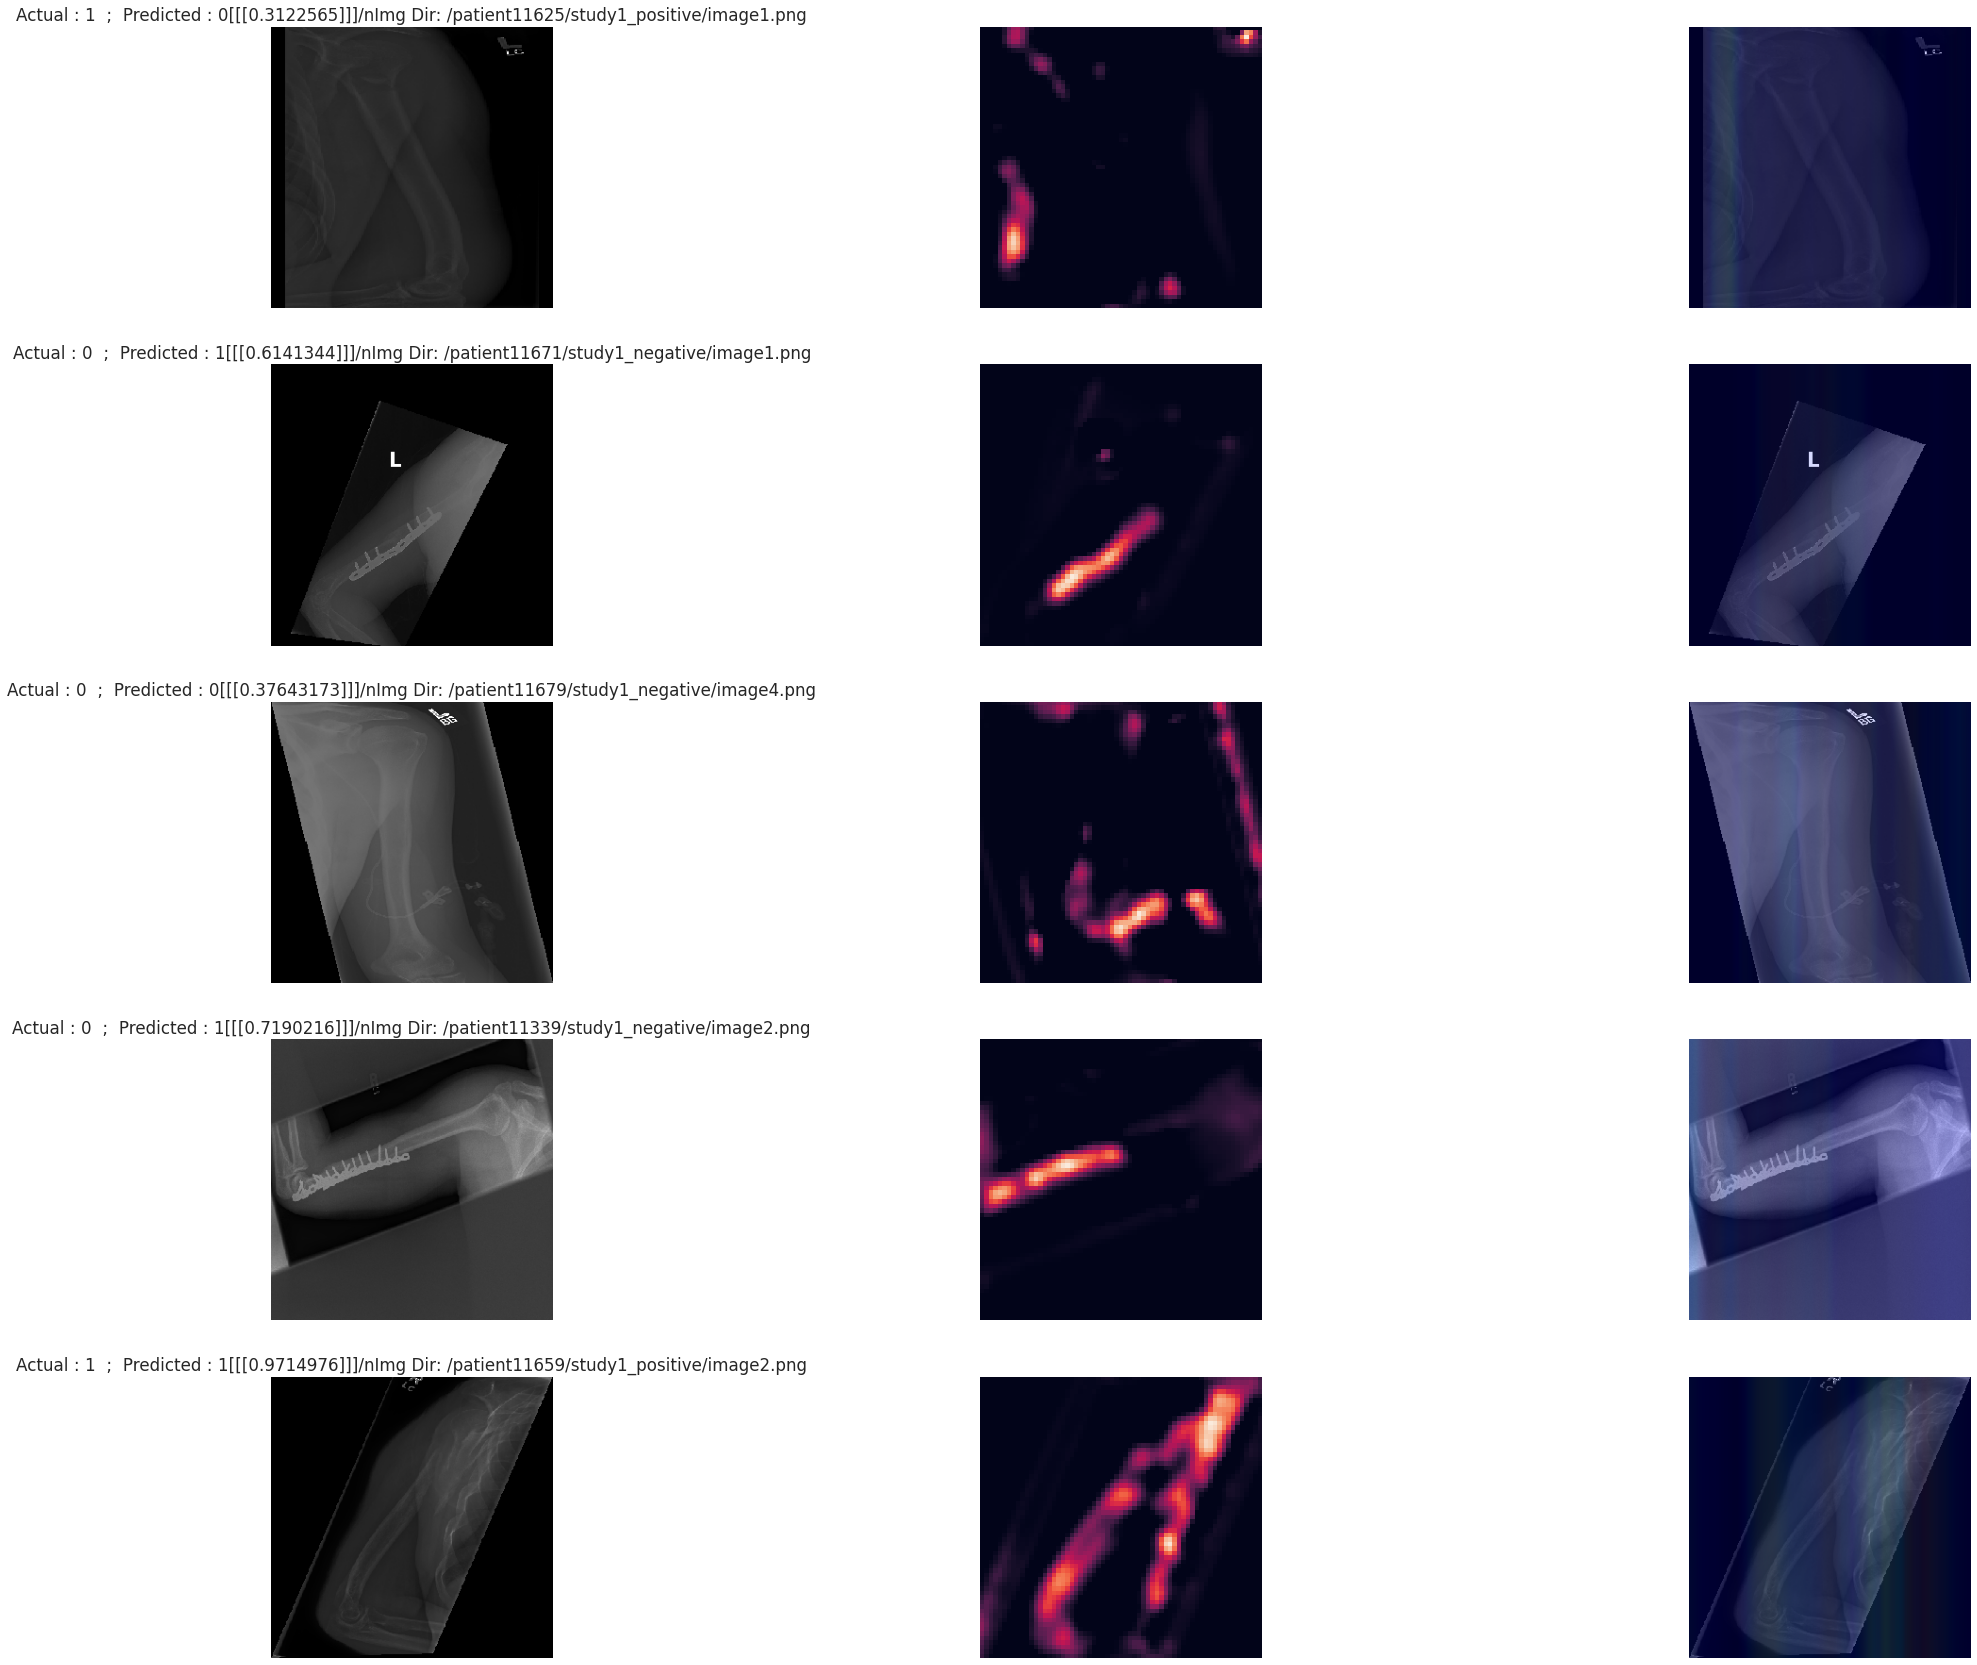

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

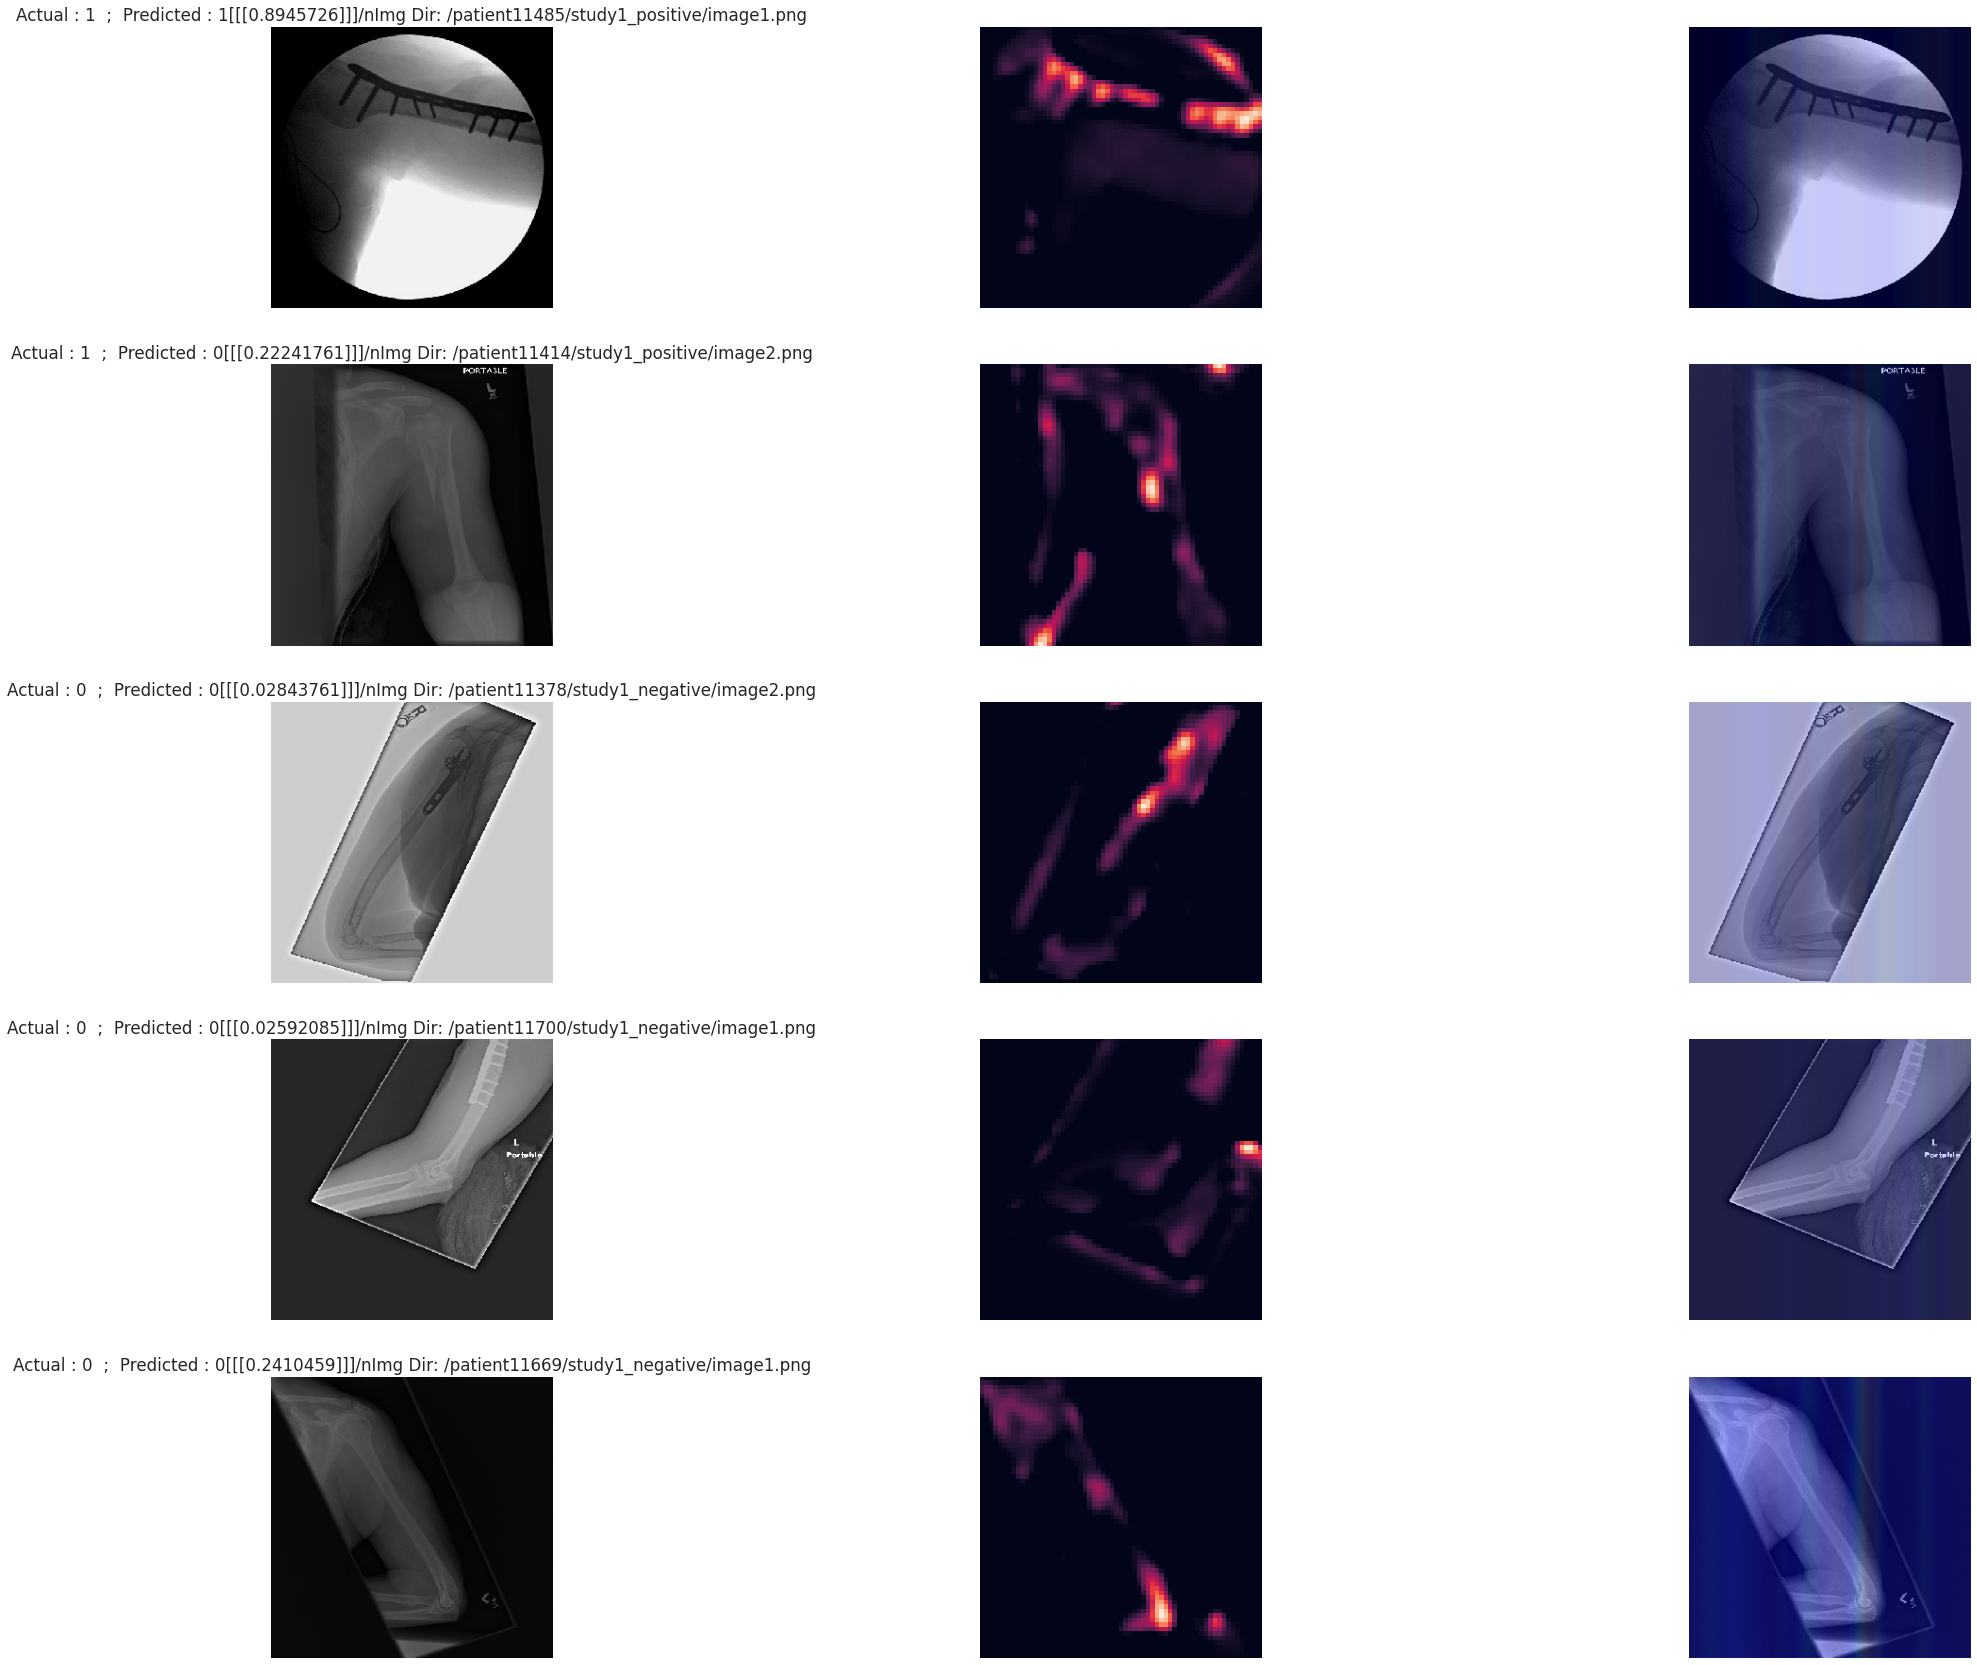

In [ ]:
study_type = "XR_HUMERUS"
grad_cam_vis(valid_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(img_height,img_width) ) #None,tp,tn,fp,fn   

## Extras(OLD)

model API

In [ ]:
# model.summary()
# model.losses
#base_model.trainable : Ans is true
# print(history.history)
# model.get_config()

**Save model**

In [ ]:
# save_dir_h5 = csv_dir+"myModels/"+filename
# # keras.models.save_model(model,save_dir_h5,save_format='h5')
# # files.download(data_dir+study_type+".png")

PLot test images

In [ ]:
# print("Number of test images: %d"%(dfv.shape[0]))
# imgv = test_dict["images"]
# labelv = test_dict["labels"]
# print("Shape of validation images: "+str(imgv.shape))
# print("min and max pixel values :  "+str(np.min(imgv))+"   "+str(np.max(imgv)))
# print("mean and std of pixel values :  "+str(np.mean(imgv))+"   "+str(np.std(imgv)))
# plt.figure(figsize=(6, 6))
# for i in range(4):
#   j = randint(0,imgv.shape[0]-1)
#   ax = plt.subplot(2,2,i+1)
#   ax.set_title(str(labelv[j]))
#   plt.imshow(imgv[j])#* 1./255)
#   plt.axis("off")

Plot augmented images

In [ ]:
# batch,label = train_iter.next()
# print(batch.shape)
# print("min and max pixel values of the batch :  "+str(np.min(batch))+"   "+str(np.max(batch)))
# print("mean and std of pixel values of the batch :  "+str(np.mean(batch))+"   "+str(np.std(batch)))
# j = randint(0,batch.shape[0]-1)
# plt.subplot(2,2,1).set_title("train, "+str(label[j]))
# plt.imshow(batch[j])#.astype('uint8'))
# plt.axis("off")
# print("---------------------------------------------------------------------")
# batch,label = valid_iter.next()
# print(batch.shape)
# print("min and max pixel values of the batch :  "+str(np.min(batch))+"   "+str(np.max(batch)))
# print("mean and std of pixel values of the batch :  "+str(np.mean(batch))+"   "+str(np.std(batch)))
# j = randint(0,batch.shape[0]-1)
# plt.subplot(2,2,2).set_title("valid, "+str(label[j]))
# plt.imshow(batch[j])#.astype('uint8'))
# plt.axis("off")

# train_iter.reset()
# valid_iter.reset()

**Train_iter:**
1. first index: 0 or 1 ((batch,label)) 
2. second index: a)0 - batch, b)1 - label
3. third index: a)for choosing img/label from that batch 

**Useful syntax:**
1. print(train_image_ds.element_spec)
2. it = iter(tf.data.Dataset)
3. .numpy()
4. train_count = tf.data.experimental.cardinality(train_aug_ds).numpy()
5. **plt.imshow(it[0][0][0].astype('uint8'))

Important from Tf tut:

1. For a layer or model, we can call them directly with image(3D tensor) or with batch(4D tensor) but need to be called with .map(lambda) with Train image dataset(Dataset obj with comps: Batch(4dtensor), label)
2. Using ds.map(), uses CPU asynch[can be solved with dataset.prefetch][After training, you can attach the preprocessing layers before export.], using preprocessing layers in model itself uses GPU synch.
3. There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

Visualising and summarising dataset

In [ ]:
# # print("Number of training images: %d"%(df.shape[0]))
# # img = train_dict["images"]
# # label = train_dict["labels"]
# # print("Shape of training images: "+str(img.shape))
# # print("min and max pixel values :  "+str(np.min(img))+"   "+str(np.max(img)))
# # print("mean and std of pixel values :  "+str(np.mean(img))+"   "+str(np.std(img)))
# # plt.figure(figsize=(6, 6))
# # for i in range(4):
# #   j = randint(0,img.shape[0]-1)
# #   ax = plt.subplot(2,2,i+1)
# #   ax.set_title(str(label[j]))
# #   plt.imshow(img[j]* 1./255)
# #   plt.axis("off")

# print("Number of validation images: %d"%(dfv.shape[0]))
# imgv = valid_dict["images"]
# labelv = valid_dict["labels"]
# print("Shape of validation images: "+str(imgv.shape))
# print("min and max pixel values :  "+str(np.min(imgv))+"   "+str(np.max(imgv)))
# print("mean and std of pixel values :  "+str(np.mean(imgv))+"   "+str(np.std(imgv)))
# plt.figure(figsize=(6, 6))
# for i in range(4):
#   j = randint(0,imgv.shape[0]-1)
#   ax = plt.subplot(2,2,i+1)
#   ax.set_title(str(labelv[j]))
#   plt.imshow(imgv[j]* 1./255)
#   plt.axis("off")

L2 regularisation

In [ ]:
# def add_regularization(model, regularizer):

#     if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
#       print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
#       return model

#     for layer in model.layers:
#         for attr in ['kernel_regularizer']:
#             if hasattr(layer, attr):
#               setattr(layer, attr, regularizer)

#     # When we change the layers attributes, the change only happens in the model config file
#     model_json = model.to_json()

#     # Save the weights before reloading the model.
#     tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
#     model.save_weights(tmp_weights_path)

#     # load the model from the config
#     model = tf.keras.models.model_from_json(model_json)
    
#     # Reload the model weights
#     model.load_weights(tmp_weights_path, by_name=True)
#     return model

# lambd = 1e-5 # [1e-6, 1e-5, 4e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]

####Testing L2 reg:
#TESTING L2 REG.
# model.losses  -------before model.fit

#TESTING L2 REG.
# model.losses  -------after model.fit

#### model = add_regularization(model, keras.regularizers.l2(lambd)) #Applying regularisation

Download model

In [ ]:
# save_dir = main_dir+"savedModels/"+"savedModel_"+study_type
# keras.models.save_model(model,save_dir)
# !zip -r ../savedModels.zip ../root/.keras/datasets/savedModels
# files.download("../savedModels.zip")
# files.download("../root/.keras/datasets/savedModels/saved_model_XR_FINGER.h5")